# Analysing FEMA's National Flood Insurance Program (NFIP) Data Using Python

In [1]:
# importing libraries
import pandas as pd # the pd is by convention
import numpy as np # as is the np
import geopandas as gpd
from geopandas.tools import overlay
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pylab as pl 
import shapely
from fiona.crs import from_epsg
import urllib
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates



# to Plot matplotlib figures inline on the notebook
%matplotlib inline

In [2]:
# changing directories to Downloads folder
%cd ~/Downloads/

/Users/geribauer/Downloads


In [3]:
# dowloading the data with urllib.request.urlretrieve()
url = 'https://www.fema.gov/media-library-data/1575491579309-2366ee38d902c1bc983370e132ee36cc/FIMA_NFIP_Redacted_Claims_Data_Set.zip'

# retrieving the file and naming it as 'nfip_claims.gz'
urllib.request.urlretrieve(url, "nfip_claims_year.gz")

('nfip_claims_year.gz', <http.client.HTTPMessage at 0x1a19f92438>)

In [4]:
# unzipping the file
!unzip -d ~/Downloads/ nfip_claims_year.gz

Archive:  nfip_claims_year.gz
  inflating: /Users/geribauer/Downloads/NFIP Claims Instructions and Metadata.xlsx  
  inflating: /Users/geribauer/Downloads/openFEMA_claims20190831.csv  


In [5]:
# moving the metadata into our nyc project data folder
%mv 'NFIP Claims Instructions and Metadata.xlsx' ~/'fema-nfip-claims/nfip-claims-national/data-dictionary/NFIP-claims-instructions-and-metadata.xlsx'

In [6]:
%cd ~/'fema-nfip-claims/nfip-claims-national/data-dictionary'
%ls

/Users/geribauer/fema-nfip-claims/nfip-claims-national/data-dictionary
NFIP-claims-instructions-and-metadata.xlsx*


In [2]:
# changing directories to Downloads folder
%cd ~/Downloads/

/Users/geribauer/Downloads


In [3]:
# read our data into a DataFrame
nfip_claims = pd.read_csv('openFEMA_claims20190831.csv')

/Users/geribauer/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,11,15,22,23,31,32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
nfip_claims.head()

,agriculturestructureindicator,asofdate,basefloodelevation,basementenclosurecrawlspacetype,reportedcity,condominiumindicator,policycount,countycode,crsdiscount,dateofloss,...,amountpaidonincreasedcostofcomplianceclaim,postfirmconstructionindicator,ratemethod,smallbusinessindicatorbuilding,state,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,yearofloss,reportedzipcode,primaryresidence
0,NaN,2019-08-31,NaN,0.0,OCEANSIDE,N,1.0,6073.0,0.00,1998-02-07,...,NaN,N,7,NaN,CA,200000.0,50000.0,1998,92056,NaN
1,NaN,2019-08-31,NaN,0.0,NEW ORLEANS,N,1.0,22071.0,0.00,2005-08-29,...,NaN,N,7,NaN,LA,100000.0,40000.0,2005,70131,Y
2,NaN,2019-08-31,NaN,0.0,NAVARRE,N,1.0,12113.0,0.05,1998-09-28,...,0.0,N,1,NaN,FL,100000.0,50000.0,1998,32566,NaN
3,NaN,2019-08-31,NaN,1.0,BEAUFORT,N,1.0,45013.0,0.00,1994-10-07,...,NaN,N,7,NaN,SC,100000.0,25000.0,1994,29902,NaN
4,NaN,2019-08-31,NaN,0.0,MELBOURNE,N,1.0,12009.0,0.00,1996-03-11,...,NaN,Y,7,NaN,FL,100000.0,25000.0,1996,32940,NaN


In [5]:
print('This dataset is as of', nfip_claims.asofdate[0], "from FEMA's Open Data Portal.")

This dataset is as of 2019-08-31 from FEMA's Open Data Portal.


In [132]:
%cd ~/fema-nfip-claims/nfip-claims-national

/Users/geribauer/fema-nfip-claims/nfip-claims-national


In [7]:
nfip_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432888 entries, 0 to 2432887
Data columns (total 39 columns):
agriculturestructureindicator                 object
asofdate                                      object
basefloodelevation                            float64
basementenclosurecrawlspacetype               float64
reportedcity                                  object
condominiumindicator                          object
policycount                                   float64
countycode                                    float64
crsdiscount                                   float64
dateofloss                                    object
elevatedbuildingindicator                     object
elevationcertificateindicator                 object
elevationdifference                           float64
censustract                                   float64
floodzone                                     object
houseworship                                  object
latitude                        

In [8]:
nfip_claims.describe()

,basefloodelevation,basementenclosurecrawlspacetype,policycount,countycode,crsdiscount,elevationdifference,censustract,latitude,longitude,lowestadjacentgrade,lowestfloorelevation,numberoffloorsintheinsuredbuilding,occupancytype,amountpaidonbuildingclaim,amountpaidoncontentsclaim,amountpaidonincreasedcostofcomplianceclaim,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,yearofloss
count,483589.000000,2.432843e+06,2.432880e+06,2.425385e+06,2.432880e+06,2.432880e+06,2.373588e+06,2.379340e+06,2.379340e+06,350723.000000,475071.000000,2.416237e+06,2.432168e+06,2.359510e+06,1.712987e+06,1.160371e+06,2.432880e+06,2.432880e+06,2.432888e+06
mean,71.378912,4.672303e-01,1.247610e+00,3.020189e+04,3.494819e-02,7.505239e+02,3.004539e+10,3.404449e+01,-8.614260e+01,75.457087,148.298637,1.722882e+00,1.404049e+00,2.367499e+04,7.729023e+03,7.600233e+02,1.512794e+05,2.819080e+04,2.000633e+03
std,300.583343,9.312251e-01,6.239860e+00,1.456152e+04,6.239606e-02,4.321235e+02,1.445356e+10,5.801293e+00,1.111013e+01,546.574281,980.141421,8.858817e-01,9.672842e-01,5.278161e+04,2.280169e+04,4.441656e+03,2.777121e+06,4.809394e+04,1.179710e+01
min,-6002.000000,0.000000e+00,1.000000e+00,1.001000e+03,0.000000e+00,-1.987000e+03,1.003000e+03,-1.430000e+01,-1.707000e+02,-3411.000000,-6002.000000,1.000000e+00,1.000000e+00,-2.920705e+04,-8.484000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.970000e+03
25%,7.000000,0.000000e+00,1.000000e+00,2.201900e+04,0.000000e+00,9.990000e+02,2.201900e+10,2.990000e+01,-9.140000e+01,3.200000,6.500000,1.000000e+00,1.000000e+00,1.085800e+02,0.000000e+00,0.000000e+00,3.500000e+04,0.000000e+00,1.992000e+03
50%,9.000000,0.000000e+00,1.000000e+00,2.916300e+04,0.000000e+00,9.990000e+02,2.912796e+10,3.190000e+01,-8.750000e+01,6.700000,10.300000,1.000000e+00,1.000000e+00,4.818810e+03,2.290000e+02,0.000000e+00,9.080000e+04,1.050000e+04,2.004000e+03
75%,14.000000,0.000000e+00,1.000000e+00,4.207500e+04,5.000000e-02,9.990000e+02,4.206195e+10,3.990000e+01,-7.690000e+01,12.900000,17.800000,2.000000e+00,1.000000e+00,2.402774e+04,5.830405e+03,0.000000e+00,1.950000e+05,4.000000e+04,2.011000e+03
max,9998.000000,4.000000e+00,1.090000e+03,7.803000e+04,4.000000e-01,9.998000e+03,7.803096e+10,6.990000e+01,1.449000e+02,99999.100000,99999.900000,6.000000e+00,6.000000e+00,1.000000e+07,7.500000e+05,6.000000e+04,4.000000e+09,6.000000e+06,2.019000e+03


In [9]:
nfip_claims.iloc[:,:15].head()

,agriculturestructureindicator,asofdate,basefloodelevation,basementenclosurecrawlspacetype,reportedcity,condominiumindicator,policycount,countycode,crsdiscount,dateofloss,elevatedbuildingindicator,elevationcertificateindicator,elevationdifference,censustract,floodzone
0,NaN,2019-08-31,NaN,0.0,OCEANSIDE,N,1.0,6073.0,0.00,1998-02-07,N,NaN,999.0,6.073019e+09,X
1,NaN,2019-08-31,NaN,0.0,NEW ORLEANS,N,1.0,22071.0,0.00,2005-08-29,N,NaN,999.0,2.207100e+10,X
2,NaN,2019-08-31,NaN,0.0,NAVARRE,N,1.0,12113.0,0.05,1998-09-28,N,NaN,999.0,1.211301e+10,X
3,NaN,2019-08-31,NaN,1.0,BEAUFORT,N,1.0,45013.0,0.00,1994-10-07,N,NaN,999.0,4.501300e+10,X
4,NaN,2019-08-31,NaN,0.0,MELBOURNE,N,1.0,12009.0,0.00,1996-03-11,N,NaN,999.0,1.200906e+10,X


In [10]:
nfip_claims.iloc[:,15:30].head()

,houseworship,latitude,locationofcontents,longitude,lowestadjacentgrade,lowestfloorelevation,numberoffloorsintheinsuredbuilding,nonprofitindicator,obstructiontype,occupancytype,originalconstructiondate,originalnbdate,amountpaidonbuildingclaim,amountpaidoncontentsclaim,amountpaidonincreasedcostofcomplianceclaim
0,NaN,33.2,NaN,-117.3,NaN,NaN,4.0,NaN,10,1.0,1963-01-01,1997-01-11,0.00,0.0,NaN
1,NaN,29.9,NaN,-90.0,NaN,NaN,2.0,NaN,10,1.0,1967-07-01,1990-07-12,0.00,0.0,NaN
2,NaN,30.4,NaN,-86.9,NaN,NaN,1.0,NaN,10,1.0,1972-01-01,1997-07-24,8813.21,1720.0,0.0
3,NaN,32.4,NaN,-80.7,NaN,NaN,2.0,NaN,10,1.0,1960-01-01,1993-10-01,2906.00,0.0,NaN
4,NaN,28.3,NaN,-80.7,NaN,NaN,1.0,NaN,10,1.0,1988-01-01,1996-01-11,3875.53,1545.0,NaN


In [11]:
nfip_claims.iloc[:,30:].head()

,postfirmconstructionindicator,ratemethod,smallbusinessindicatorbuilding,state,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,yearofloss,reportedzipcode,primaryresidence
0,N,7,NaN,CA,200000.0,50000.0,1998,92056,NaN
1,N,7,NaN,LA,100000.0,40000.0,2005,70131,Y
2,N,1,NaN,FL,100000.0,50000.0,1998,32566,NaN
3,N,7,NaN,SC,100000.0,25000.0,1994,29902,NaN
4,Y,7,NaN,FL,100000.0,25000.0,1996,32940,NaN


In [12]:
# adding a new column called 'amountpaidontotalclaim' that adds both building and contents claim to get the total claim

nfip_claims['amountpaidontotalclaim'] = nfip_claims['amountpaidonbuildingclaim'] + nfip_claims['amountpaidoncontentsclaim']

In [13]:
nfip_claims[['amountpaidonbuildingclaim', 'amountpaidoncontentsclaim', 'amountpaidontotalclaim']].head()

,amountpaidonbuildingclaim,amountpaidoncontentsclaim,amountpaidontotalclaim
0,0.00,0.0,0.00
1,0.00,0.0,0.00
2,8813.21,1720.0,10533.21
3,2906.00,0.0,2906.00
4,3875.53,1545.0,5420.53


## Group by Claim Count

In [14]:
# grouping dataframe by 'Year' and counting values of columns
nfip_claims_year_count = nfip_claims.groupby('yearofloss').count()

In [15]:
nfip_claims_year_count.head()

,agriculturestructureindicator,asofdate,basefloodelevation,basementenclosurecrawlspacetype,reportedcity,condominiumindicator,policycount,countycode,crsdiscount,dateofloss,...,amountpaidonincreasedcostofcomplianceclaim,postfirmconstructionindicator,ratemethod,smallbusinessindicatorbuilding,state,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,reportedzipcode,primaryresidence,amountpaidontotalclaim
yearofloss,,,,,,,,,,,,,,,,,,,,,
1970,0,1,0,1,1,0,1,0,1,1,...,0,0,0,0,1,1,1,1,0,0
1972,0,1,0,1,1,0,1,0,1,1,...,0,0,0,0,1,1,1,1,0,0
1973,0,9,0,9,9,0,9,6,9,9,...,0,0,0,0,9,9,9,9,0,4
1974,0,13,0,13,13,0,13,10,13,13,...,0,0,0,0,13,13,13,13,0,5
1975,0,45,0,45,45,0,45,38,45,45,...,0,0,0,0,45,45,45,45,0,25


In [16]:
nfip_claims_year_count[['asofdate']].head()

,asofdate
yearofloss,
1970,1
1972,1
1973,9
1974,13
1975,45


In [17]:
nfip_claims_year_count.rename(columns={"asofdate": "claimscount"}, inplace=True)

In [18]:
nfip_claims_year_count[['claimscount']].head()

,claimscount
yearofloss,
1970,1
1972,1
1973,9
1974,13
1975,45


In [19]:
nfip_claims_year_count = nfip_claims_year_count[['claimscount']]

In [20]:
nfip_claims_year_count.head()

,claimscount
yearofloss,
1970,1
1972,1
1973,9
1974,13
1975,45


In [21]:
nfip_claims_year_count.shape

(49, 1)

In [22]:
nfip_claims_year_count.claimscount.sum()

2432888

## Group by Claim Dollar Amount

In [23]:
nfip_claims_year_amount = nfip_claims.groupby('yearofloss').sum()

In [24]:
nfip_claims_year_amount.head()

,basefloodelevation,basementenclosurecrawlspacetype,policycount,countycode,crsdiscount,elevationdifference,censustract,latitude,longitude,lowestadjacentgrade,lowestfloorelevation,numberoffloorsintheinsuredbuilding,occupancytype,amountpaidonbuildingclaim,amountpaidoncontentsclaim,amountpaidonincreasedcostofcomplianceclaim,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,amountpaidontotalclaim
yearofloss,,,,,,,,,,,,,,,,,,,
1970,0.0,1.0,1.0,0.0,0.0,999.0,0.000000e+00,0.0,0.0,0.0,0.0,1.0,1.0,0.00,0.00,0.0,0.0,0.0,0.00
1972,0.0,0.0,1.0,0.0,0.0,999.0,0.000000e+00,0.0,0.0,0.0,0.0,1.0,1.0,0.00,0.00,0.0,0.0,0.0,0.00
1973,0.0,8.0,9.0,129444.0,0.0,6993.0,1.294467e+11,223.6,-497.8,0.0,0.0,12.0,11.0,9720.00,3547.00,0.0,101500.0,19000.0,13267.00
1974,0.0,16.0,13.0,321774.0,0.0,11185.0,2.877715e+11,333.2,-777.6,0.0,0.0,21.0,17.0,28908.00,4707.78,0.0,154500.0,91500.0,3908.00
1975,0.0,90.0,45.0,1413103.0,0.0,38158.0,1.398103e+12,1382.2,-3065.1,0.0,99.0,81.0,80.0,128774.55,99233.73,0.0,1086000.0,677800.0,97611.73


In [25]:
nfip_claims_year_amount[['amountpaidontotalclaim']].head()

,amountpaidontotalclaim
yearofloss,
1970,0.00
1972,0.00
1973,13267.00
1974,3908.00
1975,97611.73


In [26]:
nfip_claims_year_amount = nfip_claims_year_amount[['amountpaidontotalclaim']]

In [27]:
nfip_claims_year_amount.head()

,amountpaidontotalclaim
yearofloss,
1970,0.00
1972,0.00
1973,13267.00
1974,3908.00
1975,97611.73


## Join dataframes (i.e count and claim dollar amount)

In [28]:
nfip_claims_year_count.reset_index(inplace=True)
nfip_claims_year_count.head()

,yearofloss,claimscount
0,1970,1
1,1972,1
2,1973,9
3,1974,13
4,1975,45


In [29]:
nfip_claims_year_amount.reset_index(inplace=True)
nfip_claims_year_amount.head()

,yearofloss,amountpaidontotalclaim
0,1970,0.00
1,1972,0.00
2,1973,13267.00
3,1974,3908.00
4,1975,97611.73


In [30]:
nfip_claims_year = nfip_claims_year_count.merge(nfip_claims_year_amount, left_on="yearofloss", 
              right_on="yearofloss")

In [31]:
nfip_claims_year.head()

,yearofloss,claimscount,amountpaidontotalclaim
0,1970,1,0.00
1,1972,1,0.00
2,1973,9,13267.00
3,1974,13,3908.00
4,1975,45,97611.73


In [32]:
nfip_claims_year['average_paid_flood_claim'] = nfip_claims_year['amountpaidontotalclaim'] / nfip_claims_year['claimscount']

In [33]:
nfip_claims_year.head()

,yearofloss,claimscount,amountpaidontotalclaim,average_paid_flood_claim
0,1970,1,0.00,0.000000
1,1972,1,0.00,0.000000
2,1973,9,13267.00,1474.111111
3,1974,13,3908.00,300.615385
4,1975,45,97611.73,2169.149556


In [34]:
nfip_claims_year.round({'average_paid_flood_claim': 2}).head()

,yearofloss,claimscount,amountpaidontotalclaim,average_paid_flood_claim
0,1970,1,0.00,0.00
1,1972,1,0.00,0.00
2,1973,9,13267.00,1474.11
3,1974,13,3908.00,300.62
4,1975,45,97611.73,2169.15


In [35]:
nfip_claims_year = nfip_claims_year.round({'average_paid_flood_claim': 2})

In [36]:
nfip_claims_year.head()

,yearofloss,claimscount,amountpaidontotalclaim,average_paid_flood_claim
0,1970,1,0.00,0.00
1,1972,1,0.00,0.00
2,1973,9,13267.00,1474.11
3,1974,13,3908.00,300.62
4,1975,45,97611.73,2169.15


## Formatting to create timeseries plot

In [37]:
# setting index to 'dateofloss' column
nfip_claims_year.set_index('yearofloss', drop=False, inplace=True)
nfip_claims_year.head()

,yearofloss,claimscount,amountpaidontotalclaim,average_paid_flood_claim
yearofloss,,,,
1970,1970,1,0.00,0.00
1972,1972,1,0.00,0.00
1973,1973,9,13267.00,1474.11
1974,1974,13,3908.00,300.62
1975,1975,45,97611.73,2169.15


In [38]:
# transforming our 'Year' index to datetime
nfip_claims_year.index = pd.to_datetime(nfip_claims_year.index, format='%Y')

In [39]:
nfip_claims_year.index.dtype

dtype('<M8[ns]')

In [40]:
nfip_claims_year.head()

,yearofloss,claimscount,amountpaidontotalclaim,average_paid_flood_claim
yearofloss,,,,
1970-01-01,1970,1,0.00,0.00
1972-01-01,1972,1,0.00,0.00
1973-01-01,1973,9,13267.00,1474.11
1974-01-01,1974,13,3908.00,300.62
1975-01-01,1975,45,97611.73,2169.15


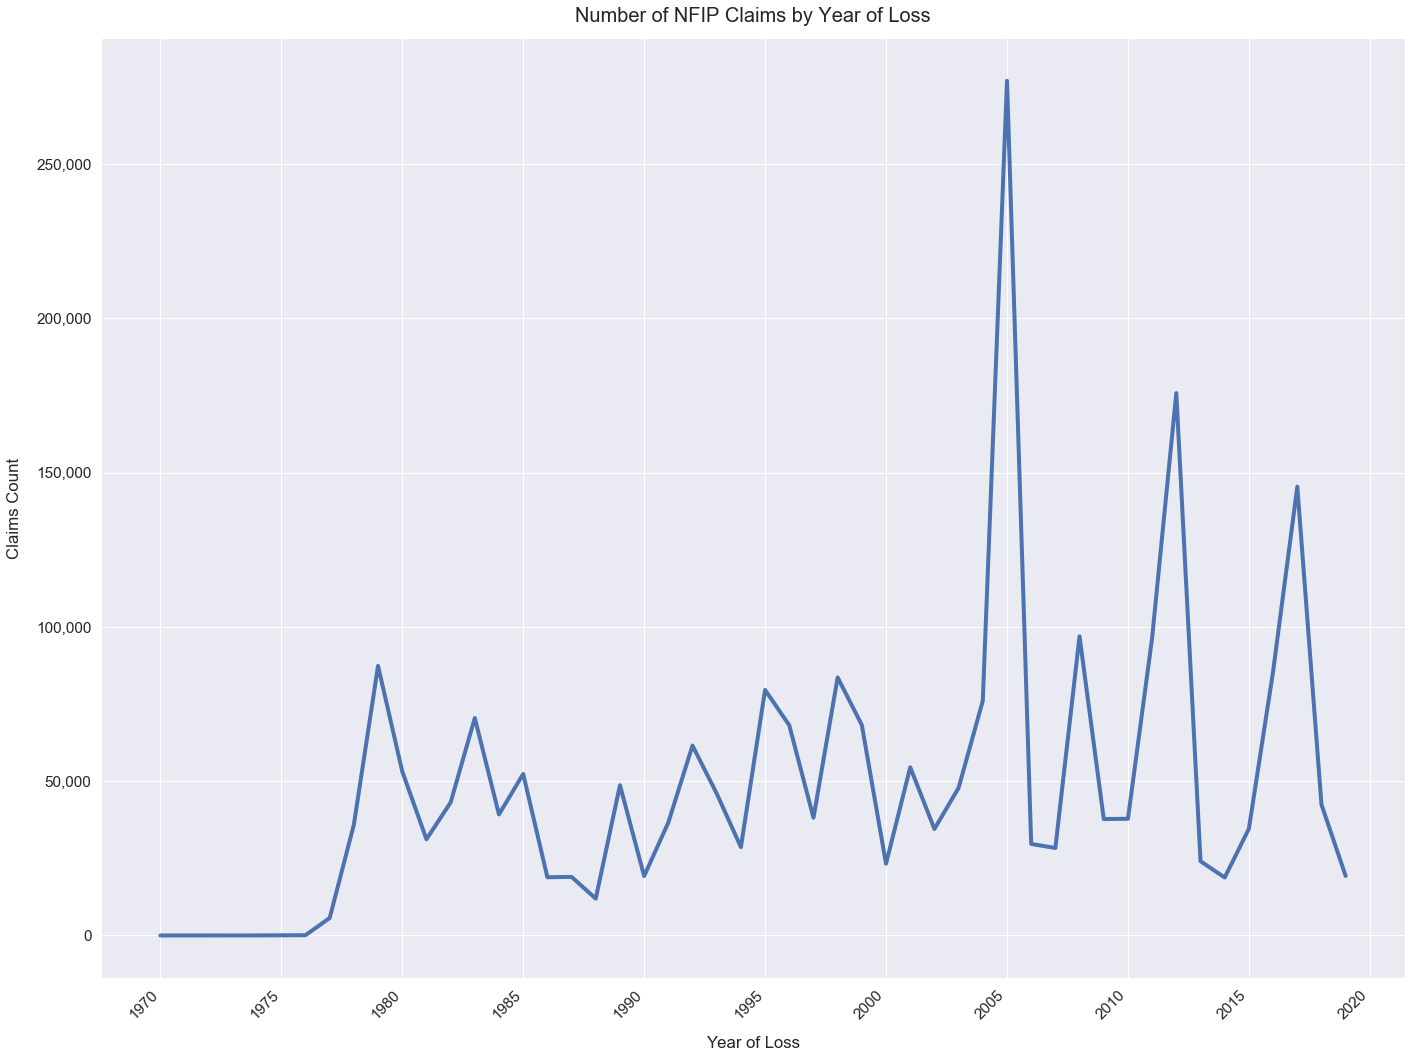

In [52]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


years = mdates.YearLocator(5)   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# plotting bar chart of number of claims by year
nfip_claims_year['claimscount'].plot(ax=ax, color='b', legend=False, rot=45, linewidth=4)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Claims Count", labelpad=14)
plt.title("Number of NFIP Claims by Year of Loss", pad=16, fontsize=20)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-year-count.png')

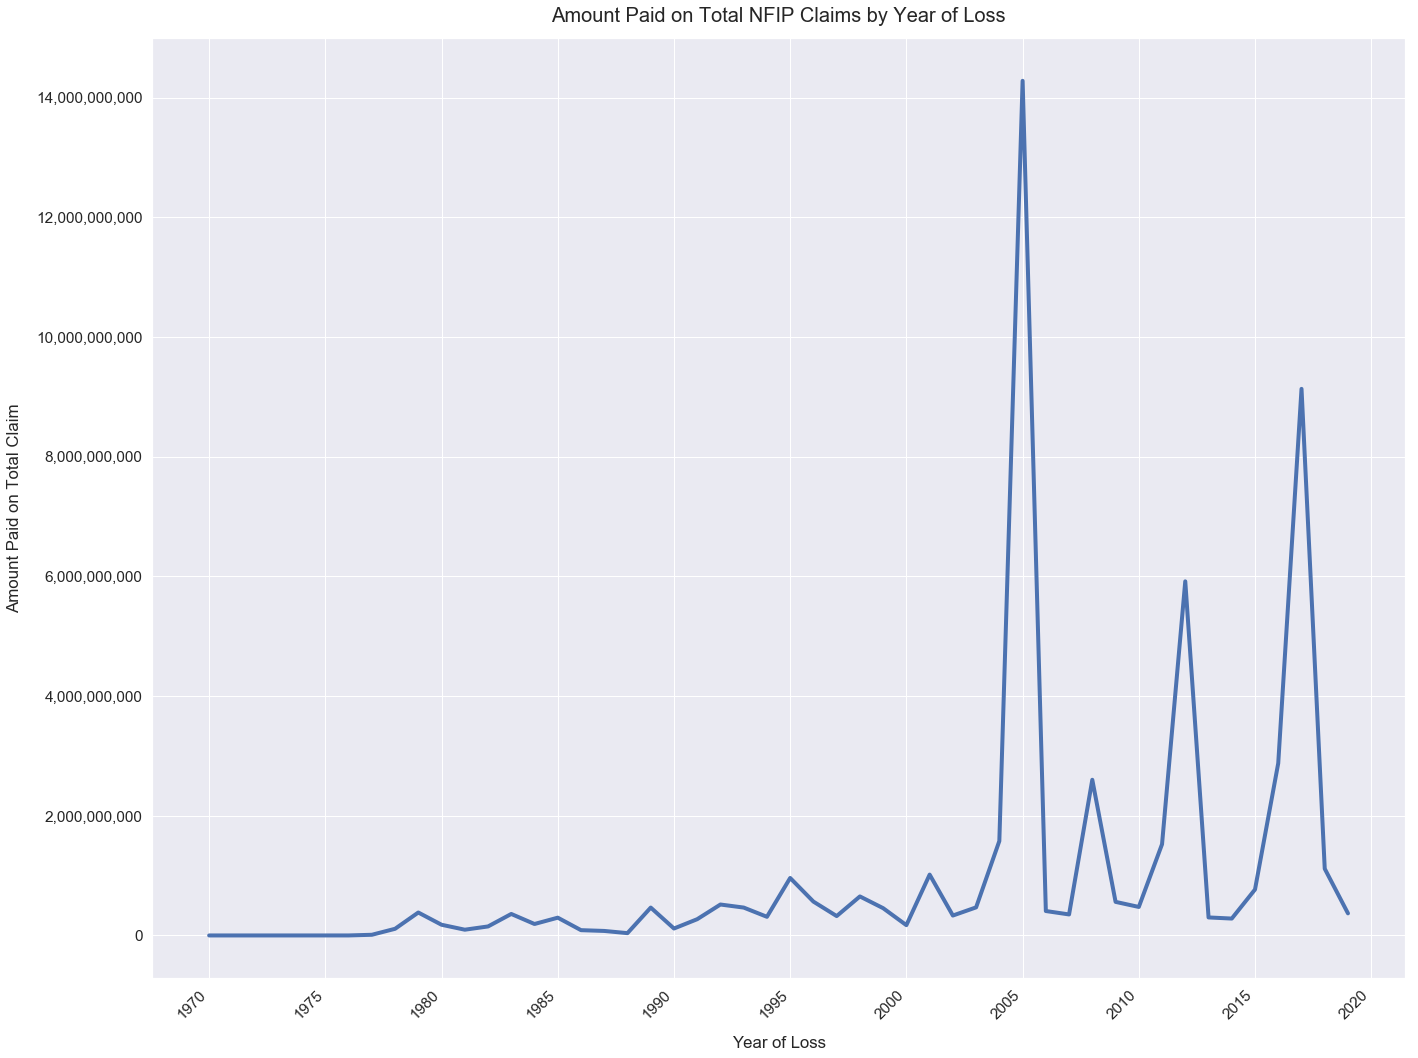

In [53]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


years = mdates.YearLocator(5)   # every 5 year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# plotting bar chart of number of claims by year
nfip_claims_year['amountpaidontotalclaim'].plot(ax=ax, color='b', legend=False, rot=45, linewidth=4)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Amount Paid on Total Claim", labelpad=14)
plt.title("Amount Paid on Total NFIP Claims by Year of Loss", pad=16, fontsize=20)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-year-amount.png')

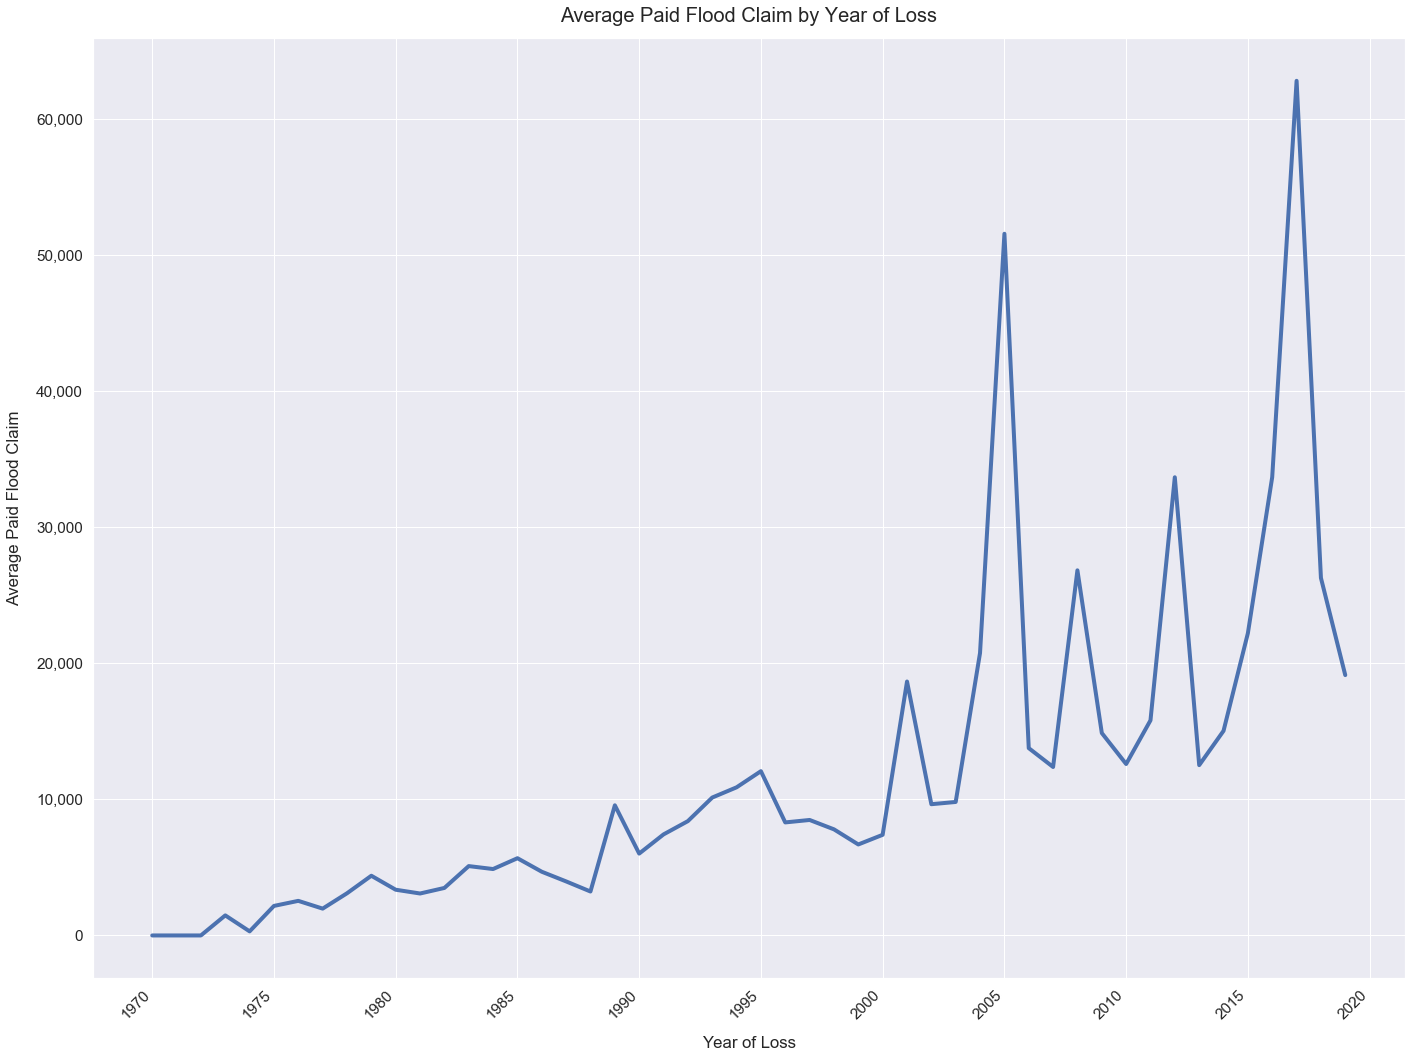

In [54]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


years = mdates.YearLocator(5)   # every 5 year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# plotting bar chart of number of claims by year
nfip_claims_year['average_paid_flood_claim'].plot(ax=ax, color='b', legend=False, rot=45, linewidth=4)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Average Paid Flood Claim", labelpad=14)
plt.title("Average Paid Flood Claim by Year of Loss", pad=16, fontsize=20)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-year-average.png')

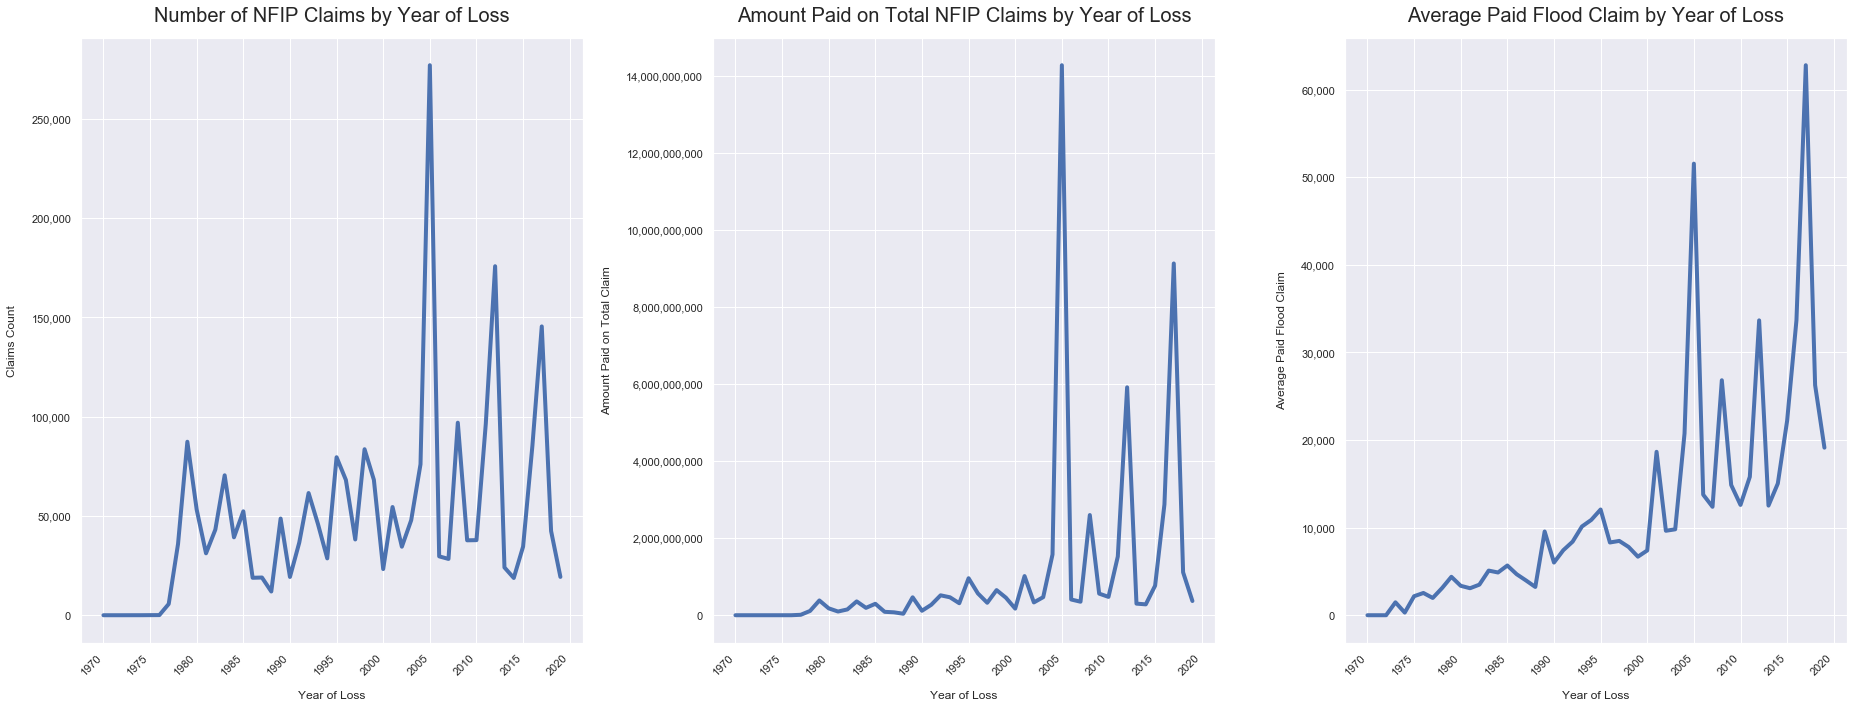

In [142]:
sns.set(font_scale=1)
fig = pl.figure(figsize=(26,10))

# adding first subplot
ax = fig.add_subplot(131)

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


years = mdates.YearLocator(5)   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# plotting bar chart of number of claims by year
nfip_claims_year['claimscount'].plot(ax=ax, color='b', legend=False, rot=45, linewidth=4)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Claims Count", labelpad=14)
plt.title("Number of NFIP Claims by Year of Loss", pad=16, fontsize=20)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# adding second subplot
ax = fig.add_subplot(132)

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


years = mdates.YearLocator(5)   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# plotting bar chart of number of claims by year
nfip_claims_year['amountpaidontotalclaim'].plot(ax=ax, color='b', legend=False, rot=45, linewidth=4)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Amount Paid on Total Claim", labelpad=14)
plt.title("Amount Paid on Total NFIP Claims by Year of Loss", pad=16, fontsize=20)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# adding third subplot
ax = fig.add_subplot(133)

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


years = mdates.YearLocator(5)   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# plotting bar chart of number of claims by year
nfip_claims_year['average_paid_flood_claim'].plot(ax=ax, color='b', legend=False, rot=45, linewidth=4)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Average Paid Flood Claim", labelpad=14)
plt.title("Average Paid Flood Claim by Year of Loss", pad=16, fontsize=20)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-year-subplots.png')

In [41]:
nfip_claims_year.sort_values(by='claimscount', ascending=False).head(10)

,yearofloss,claimscount,amountpaidontotalclaim,average_paid_flood_claim
yearofloss,,,,
2005-01-01,2005,277024,1.428216e+10,51555.69
2012-01-01,2012,175789,5.917678e+09,33663.53
2017-01-01,2017,145466,9.134276e+09,62793.20
2008-01-01,2008,96972,2.601392e+09,26826.22
2011-01-01,2011,96461,1.524503e+09,15804.34
1979-01-01,1979,87375,3.833123e+08,4386.98
2016-01-01,2016,85463,2.877588e+09,33670.57
1998-01-01,1998,83621,6.519203e+08,7796.13
1995-01-01,1995,79582,9.605043e+08,12069.37


In [42]:
nfip_claims_year.sort_values(by='amountpaidontotalclaim', ascending=False).head(10)

,yearofloss,claimscount,amountpaidontotalclaim,average_paid_flood_claim
yearofloss,,,,
2005-01-01,2005,277024,1.428216e+10,51555.69
2017-01-01,2017,145466,9.134276e+09,62793.20
2012-01-01,2012,175789,5.917678e+09,33663.53
2016-01-01,2016,85463,2.877588e+09,33670.57
2008-01-01,2008,96972,2.601392e+09,26826.22
2004-01-01,2004,76033,1.577862e+09,20752.32
2011-01-01,2011,96461,1.524503e+09,15804.34
2018-01-01,2018,42429,1.114654e+09,26271.04
2001-01-01,2001,54492,1.016633e+09,18656.55


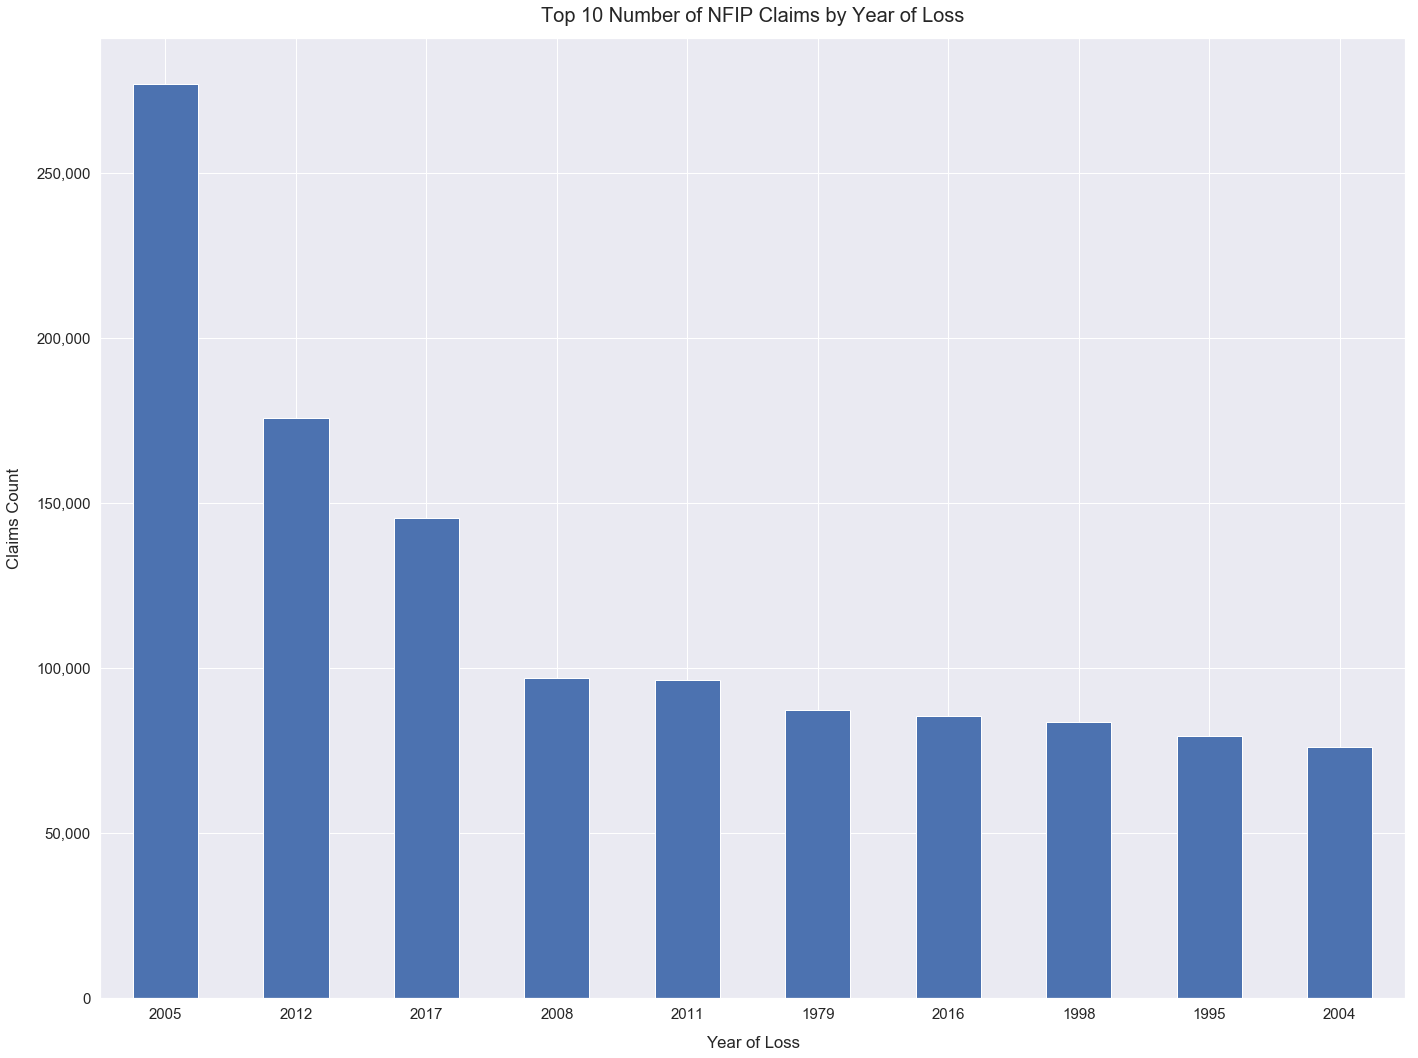

In [74]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_year.sort_values(by='claimscount', ascending=False).head(10).plot.bar(x='yearofloss', y='claimscount', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Claims Count", labelpad=14)
plt.title("Top 10 Number of NFIP Claims by Year of Loss", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-year-count-top10.png')

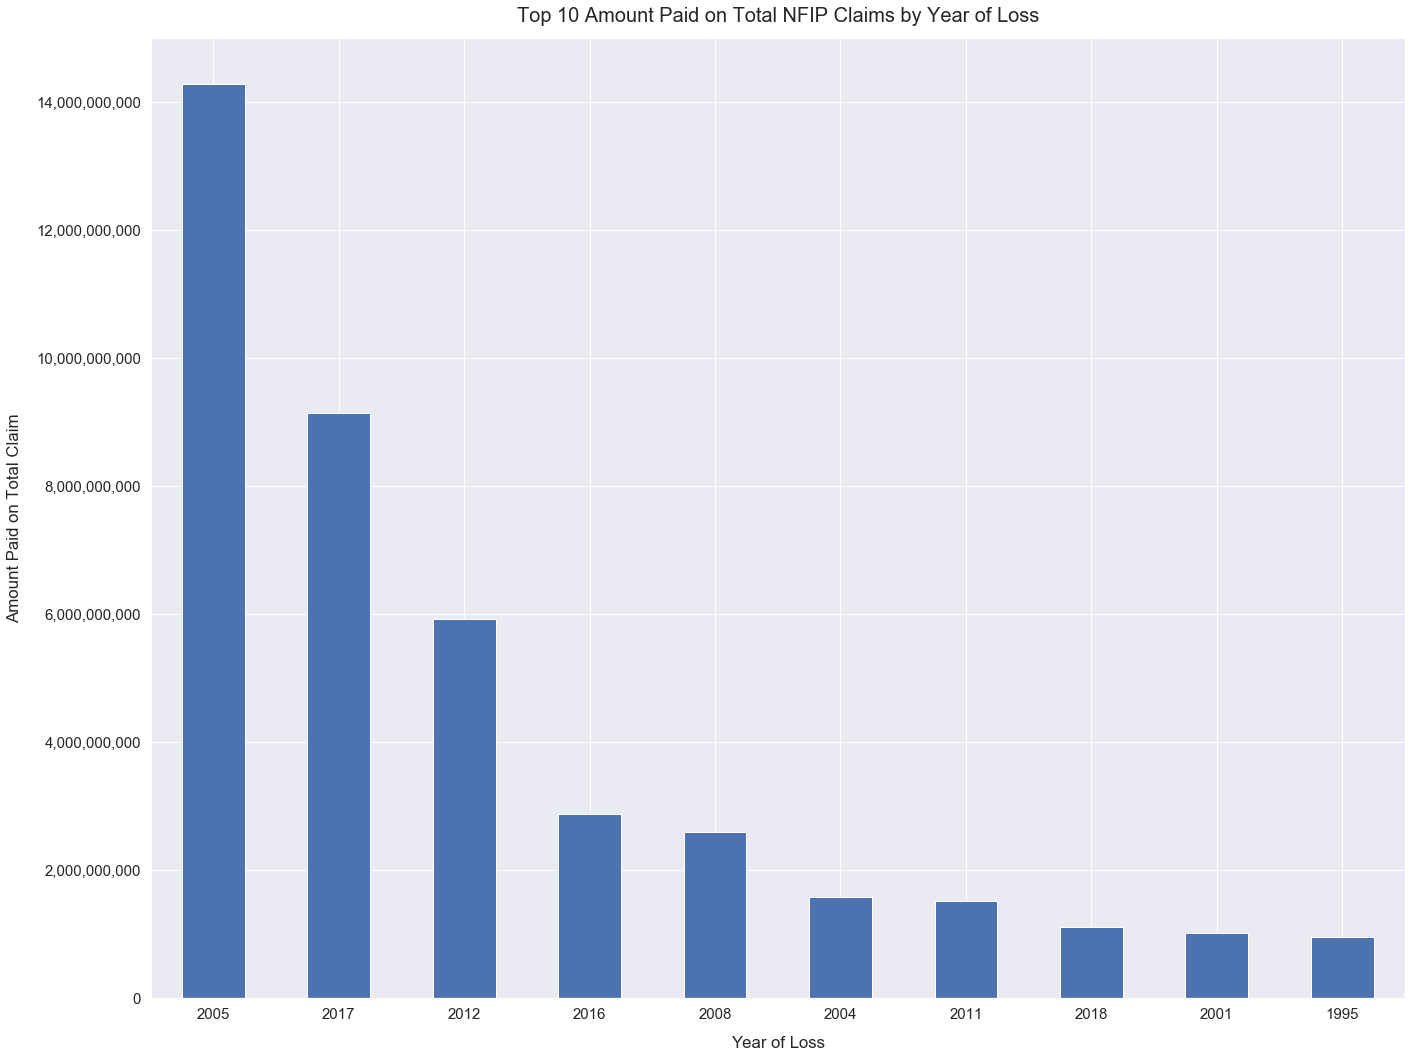

In [77]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_year.sort_values(by='amountpaidontotalclaim', ascending=False).head(10).plot.bar(x='yearofloss', y='amountpaidontotalclaim', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Amount Paid on Total Claim", labelpad=14)
plt.title("Top 10 Amount Paid on Total NFIP Claims by Year of Loss", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-year-amount-top10.png')

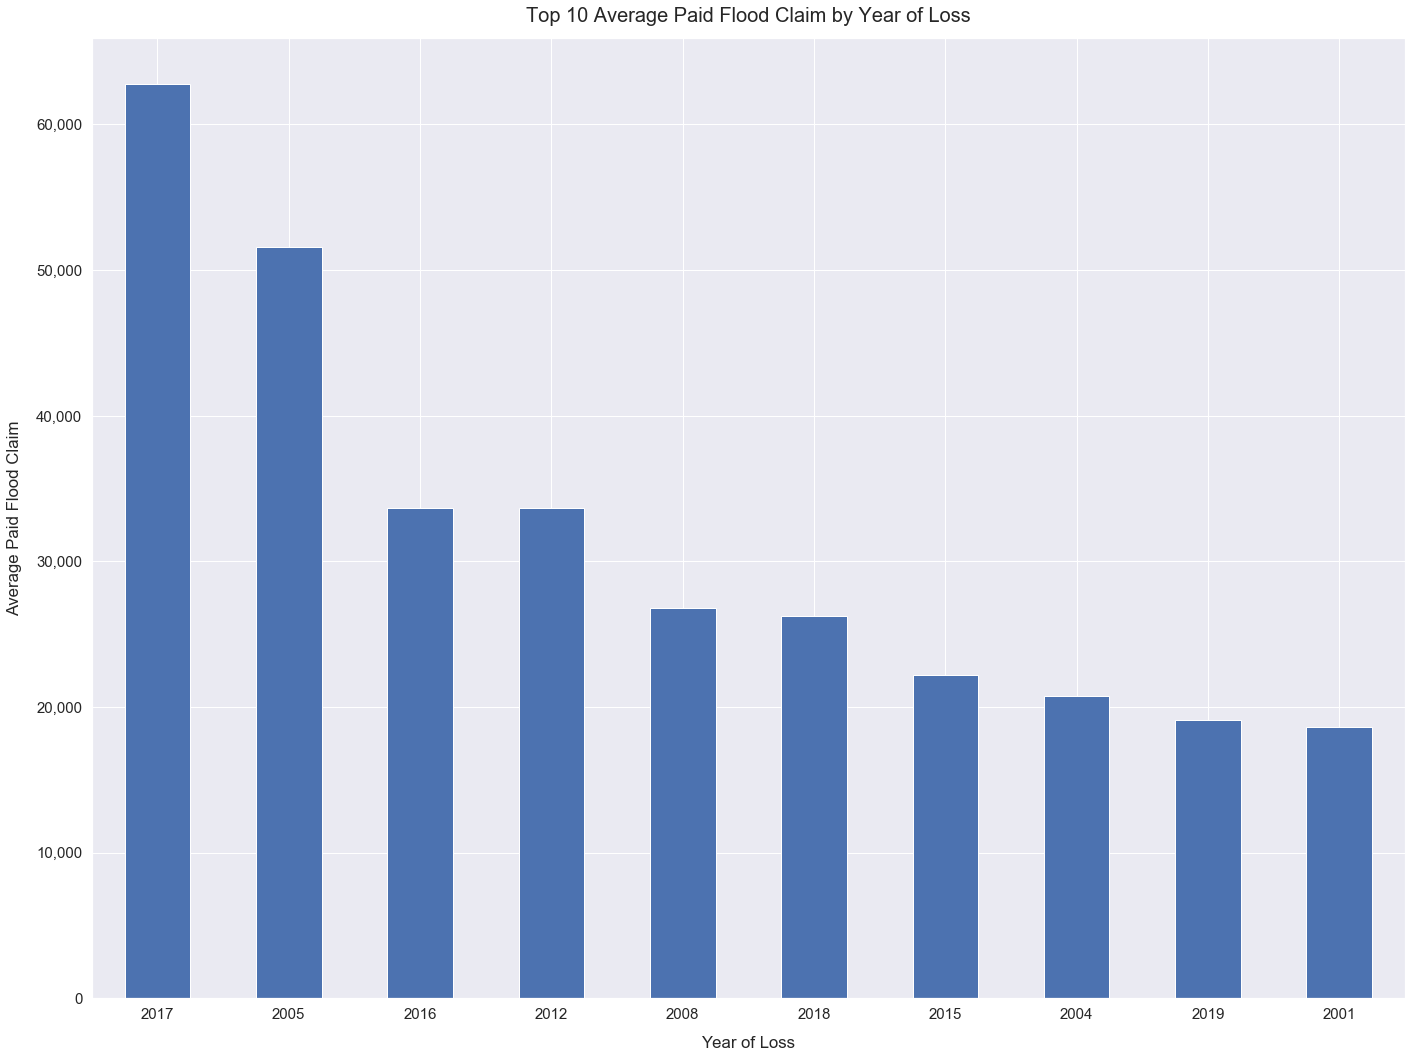

In [78]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_year.sort_values(by='average_paid_flood_claim', ascending=False).head(10).plot.bar(x='yearofloss', y='average_paid_flood_claim', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("Year of Loss", labelpad=14)
plt.ylabel("Average Paid Flood Claim", labelpad=14)
plt.title("Top 10 Average Paid Flood Claim by Year of Loss", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-year-average-top10.png')

## Analyzing NFIP Claims by State

### Group by Claims Count

In [43]:
# grouping dataframe by 'Year' and summing values of columns
nfip_claims_state_count = nfip_claims.groupby('state').count()

In [44]:
nfip_claims_state_count.head()

,agriculturestructureindicator,asofdate,basefloodelevation,basementenclosurecrawlspacetype,reportedcity,condominiumindicator,policycount,countycode,crsdiscount,dateofloss,...,amountpaidonincreasedcostofcomplianceclaim,postfirmconstructionindicator,ratemethod,smallbusinessindicatorbuilding,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,yearofloss,reportedzipcode,primaryresidence,amountpaidontotalclaim
state,,,,,,,,,,,,,,,,,,,,,
AK,9,666,161,666,664,657,666,660,666,666,...,260,642,658,18,666,666,666,664,375,373
AL,523,40599,14269,40599,40492,40222,40599,40584,40599,40599,...,20851,40087,40193,775,40599,40599,40599,40585,22425,29416
AR,971,9523,1003,9523,9490,9229,9523,9521,9523,9523,...,4670,9186,9204,1396,9523,9523,9523,9521,5909,4700
AS,3,10,0,10,10,10,10,9,10,10,...,2,5,10,3,10,10,10,10,8,6
AZ,164,4946,365,4946,4929,4603,4946,4930,4946,4946,...,1109,4614,4607,279,4946,4946,4946,4943,1737,2651


In [45]:
nfip_claims_state_count = nfip_claims_state_count[['asofdate']]

In [46]:
nfip_claims_state_count.head()

,asofdate
state,
AK,666
AL,40599
AR,9523
AS,10
AZ,4946


In [47]:
nfip_claims_state_count.rename(columns={"asofdate": "claimscount"}, inplace=True)
nfip_claims_state_count.head()

,claimscount
state,
AK,666
AL,40599
AR,9523
AS,10
AZ,4946


### Group by Claims Amount

In [48]:
# grouping dataframe by 'Year' and summing values of columns
nfip_claims_state_amount = nfip_claims.groupby('state').sum()

In [49]:
nfip_claims_state_amount.head()

,basefloodelevation,basementenclosurecrawlspacetype,policycount,countycode,crsdiscount,elevationdifference,censustract,latitude,longitude,lowestadjacentgrade,lowestfloorelevation,numberoffloorsintheinsuredbuilding,occupancytype,amountpaidonbuildingclaim,amountpaidoncontentsclaim,amountpaidonincreasedcostofcomplianceclaim,totalbuildinginsurancecoverage,totalcontentsinsurancecoverage,yearofloss,amountpaidontotalclaim
state,,,,,,,,,,,,,,,,,,,,
AK,44248.1,426.0,666.0,1400886.0,5.45,453777.0,1.339775e+12,39960.0,-9.520680e+04,33220.2,43026.7,1224.0,894.0,8.945638e+06,8.386107e+05,69548.00,8.189950e+07,1.522620e+07,1332343,6.099740e+06
AL,494187.0,11355.0,71655.0,42719338.0,1111.50,23409931.0,4.094744e+13,1210566.0,-3.425905e+06,328303.9,666758.4,62040.0,57939.0,8.348860e+08,1.849580e+08,12251093.49,7.941595e+09,1.124825e+09,81120056,7.109623e+08
AR,323663.3,3072.0,9573.0,48369911.0,81.95,8216244.0,4.724463e+13,325975.7,-8.558871e+05,314951.6,496133.6,13570.0,14900.0,1.547217e+08,2.761008e+07,2028797.87,7.332164e+08,1.725738e+08,19061928,1.124162e+08
AS,0.0,0.0,10.0,540450.0,0.00,9990.0,5.404500e+11,-128.7,-1.536300e+03,0.0,0.0,5.0,20.0,2.467571e+04,1.141024e+04,0.00,2.099000e+05,2.790000e+04,20089,3.608595e+04
AZ,541648.9,1212.0,5038.0,19793438.0,178.50,4524232.0,1.913964e+13,159932.1,-5.344809e+05,453078.2,533497.6,6846.0,7517.0,4.380385e+07,8.158692e+06,50000.00,4.720032e+08,9.819450e+07,9862732,3.321921e+07


In [50]:
nfip_claims_state_amount = nfip_claims_state_amount[['amountpaidontotalclaim']]

In [51]:
nfip_claims_state_amount.head()

,amountpaidontotalclaim
state,
AK,6.099740e+06
AL,7.109623e+08
AR,1.124162e+08
AS,3.608595e+04
AZ,3.321921e+07


### Merging both dataframes (i.e. claims count and amount)

In [52]:
nfip_claims_state_count.reset_index(inplace=True)
nfip_claims_state_amount.reset_index(inplace=True)

In [53]:
# merging both data frames (count and claim amount) by borough name
nfip_claims_state = nfip_claims_state_count.merge(nfip_claims_state_amount, left_on="state", 
              right_on="state")

In [54]:
nfip_claims_state.head()

,state,claimscount,amountpaidontotalclaim
0,AK,666,6.099740e+06
1,AL,40599,7.109623e+08
2,AR,9523,1.124162e+08
3,AS,10,3.608595e+04
4,AZ,4946,3.321921e+07


In [55]:
nfip_claims_state['average_paid_flood_claim'] = nfip_claims_state['amountpaidontotalclaim'] / nfip_claims_state['claimscount']

In [56]:
nfip_claims_state.head()

,state,claimscount,amountpaidontotalclaim,average_paid_flood_claim
0,AK,666,6.099740e+06,9158.769099
1,AL,40599,7.109623e+08,17511.818956
2,AR,9523,1.124162e+08,11804.704301
3,AS,10,3.608595e+04,3608.595000
4,AZ,4946,3.321921e+07,6716.378104


In [57]:
nfip_claims_state.sort_values(by='claimscount', ascending=False).head(10)

,state,claimscount,amountpaidontotalclaim,average_paid_flood_claim
20,LA,458785,1.528993e+10,33327.013426
46,TX,371422,1.388445e+10,37381.865907
10,FL,295451,4.137530e+09,14004.115658
33,NJ,192679,3.594193e+09,18653.789199
36,NY,169501,3.313827e+09,19550.488199
29,NC,101247,1.277994e+09,12622.535248
40,PA,73523,8.176414e+08,11120.893108
27,MS,62715,2.460968e+09,39240.493723
16,IL,51837,3.227074e+08,6225.425972
5,CA,50294,3.619649e+08,7196.979578


In [58]:
nfip_claims_state.sort_values(by='amountpaidontotalclaim', ascending=False).head(10)

,state,claimscount,amountpaidontotalclaim,average_paid_flood_claim
20,LA,458785,1.528993e+10,33327.013426
46,TX,371422,1.388445e+10,37381.865907
10,FL,295451,4.137530e+09,14004.115658
33,NJ,192679,3.594193e+09,18653.789199
36,NY,169501,3.313827e+09,19550.488199
27,MS,62715,2.460968e+09,39240.493723
29,NC,101247,1.277994e+09,12622.535248
40,PA,73523,8.176414e+08,11120.893108
1,AL,40599,7.109623e+08,17511.818956
43,SC,45728,6.147902e+08,13444.501462


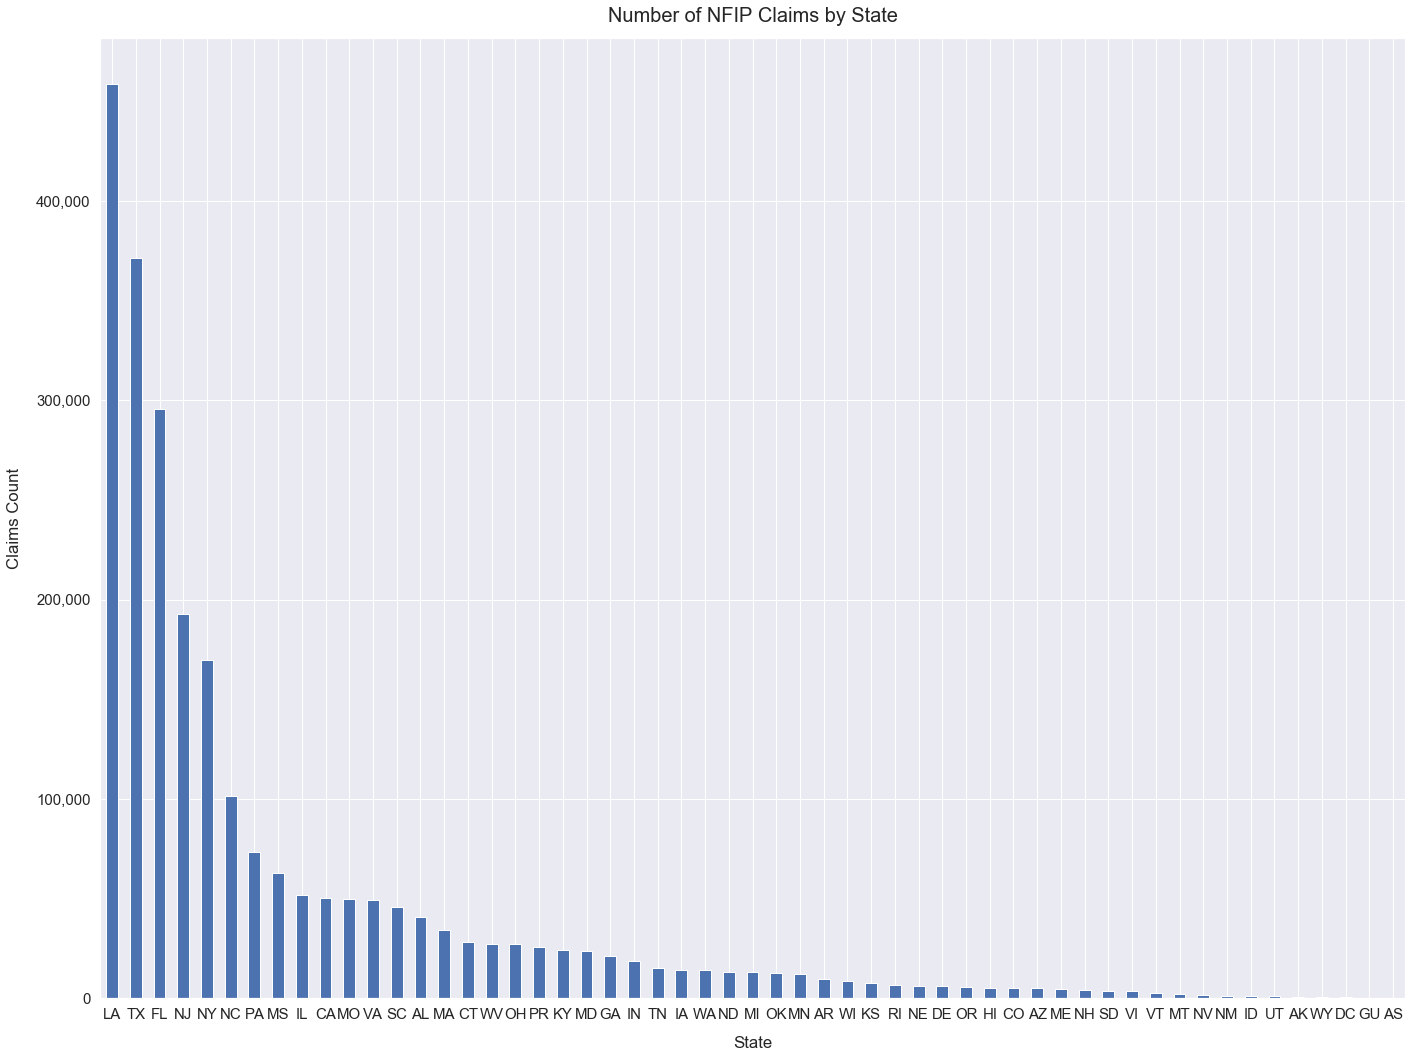

In [63]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_state.sort_values(by='claimscount', ascending=False).plot.bar(x='state', y='claimscount', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("State", labelpad=14)
plt.ylabel("Claims Count", labelpad=14)
plt.title("Number of NFIP Claims by State", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-state-count.png')

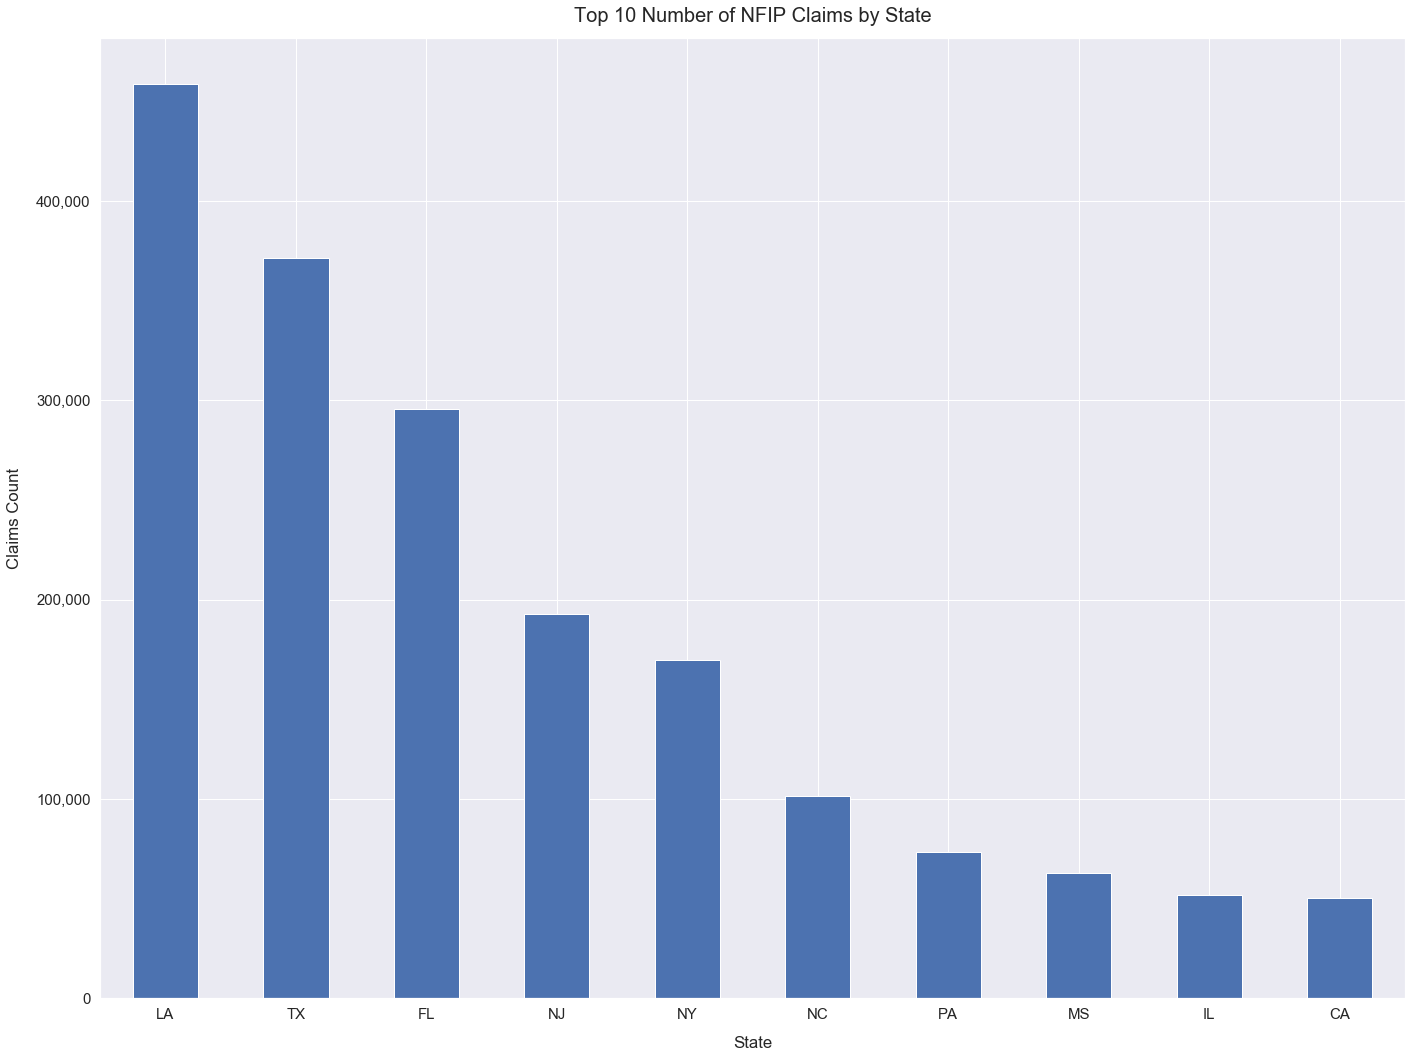

In [64]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_state.sort_values(by='claimscount', ascending=False).head(10).plot.bar(x='state', y='claimscount', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("State", labelpad=14)
plt.ylabel("Claims Count", labelpad=14)
plt.title("Top 10 Number of NFIP Claims by State", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-state-count-top10.png')

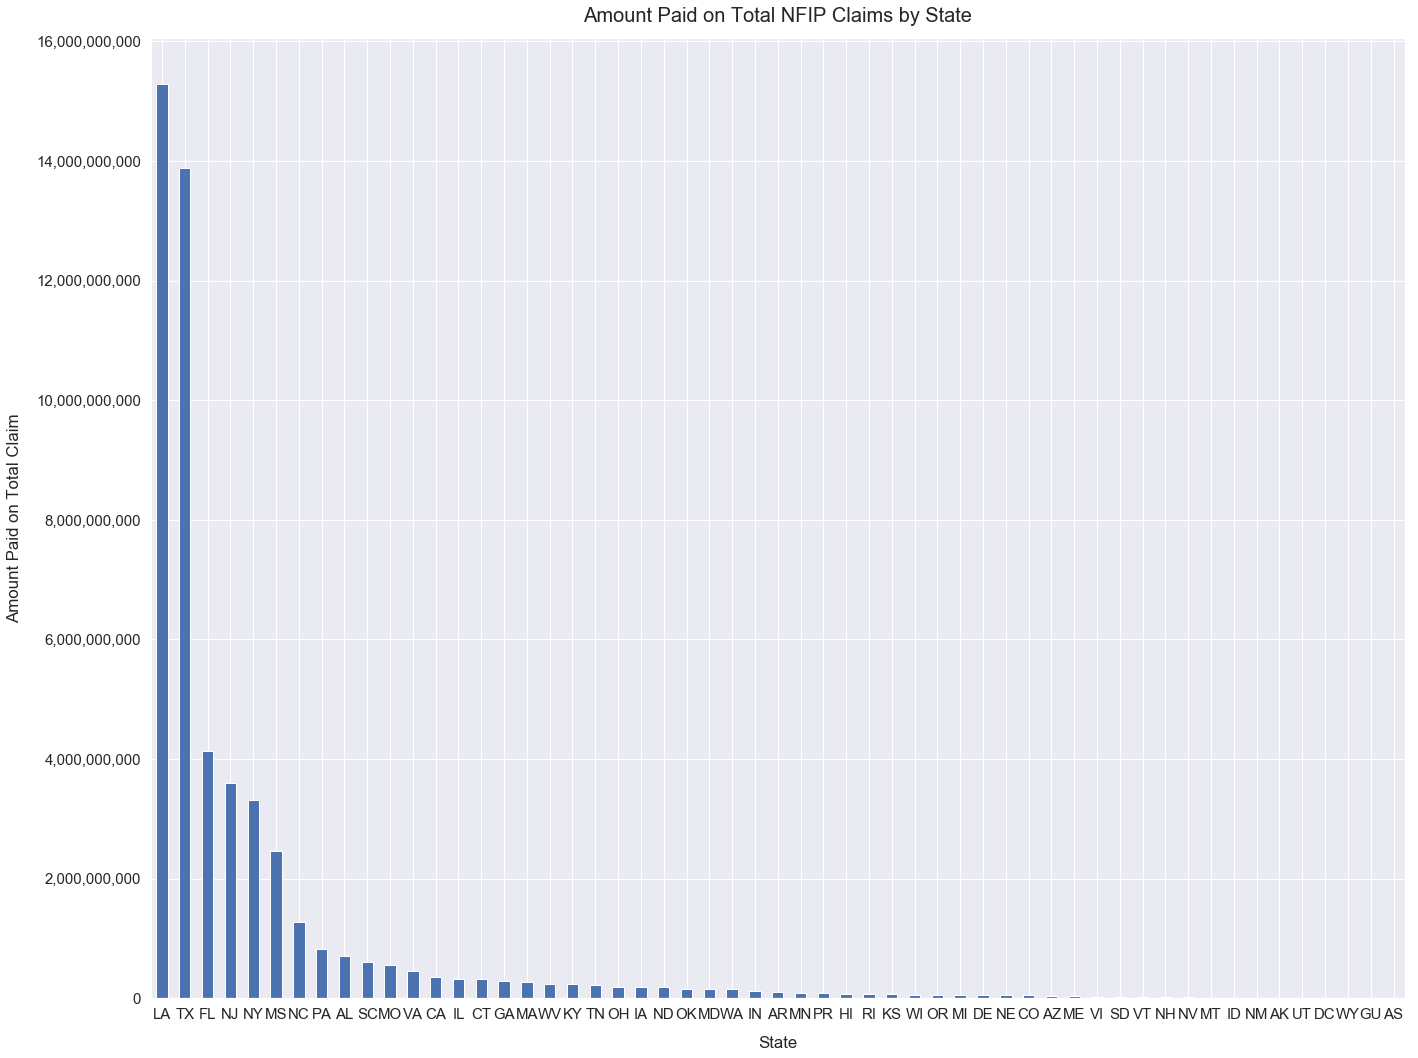

In [65]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_state.sort_values(by='amountpaidontotalclaim', ascending=False).plot.bar(x='state', y='amountpaidontotalclaim', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("State", labelpad=14)
plt.ylabel("Amount Paid on Total Claim", labelpad=14)
plt.title("Amount Paid on Total NFIP Claims by State", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-state-amount.png')

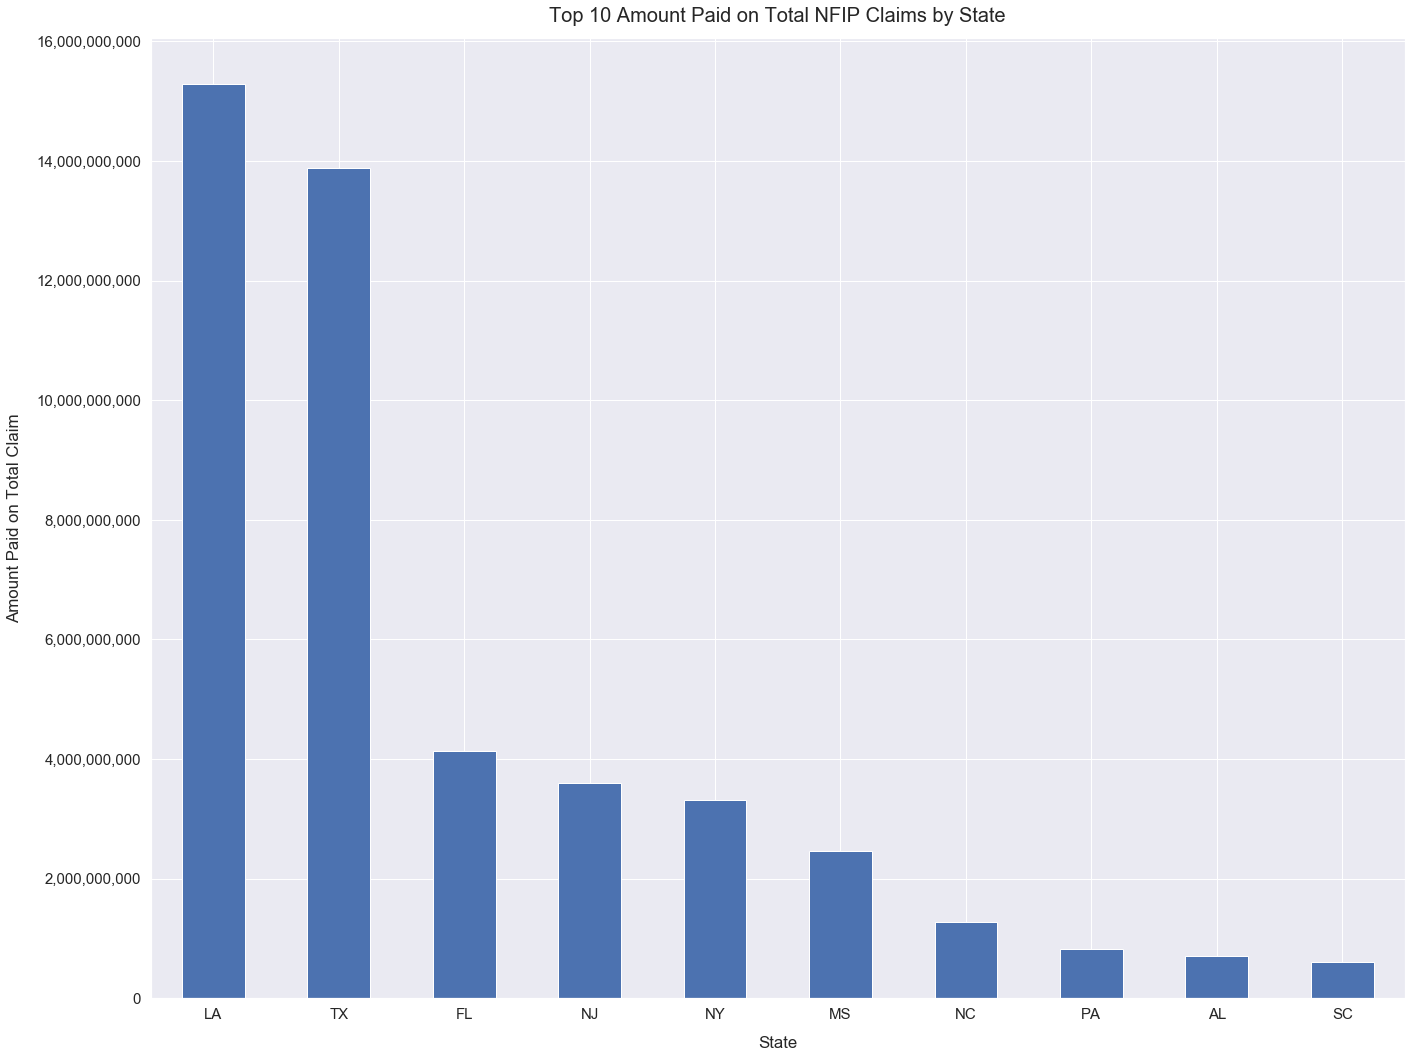

In [66]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_state.sort_values(by='amountpaidontotalclaim', ascending=False).head(10).plot.bar(x='state', y='amountpaidontotalclaim', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("State", labelpad=14)
plt.ylabel("Amount Paid on Total Claim", labelpad=14)
plt.title("Top 10 Amount Paid on Total NFIP Claims by State", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-state-amount-top10.png')

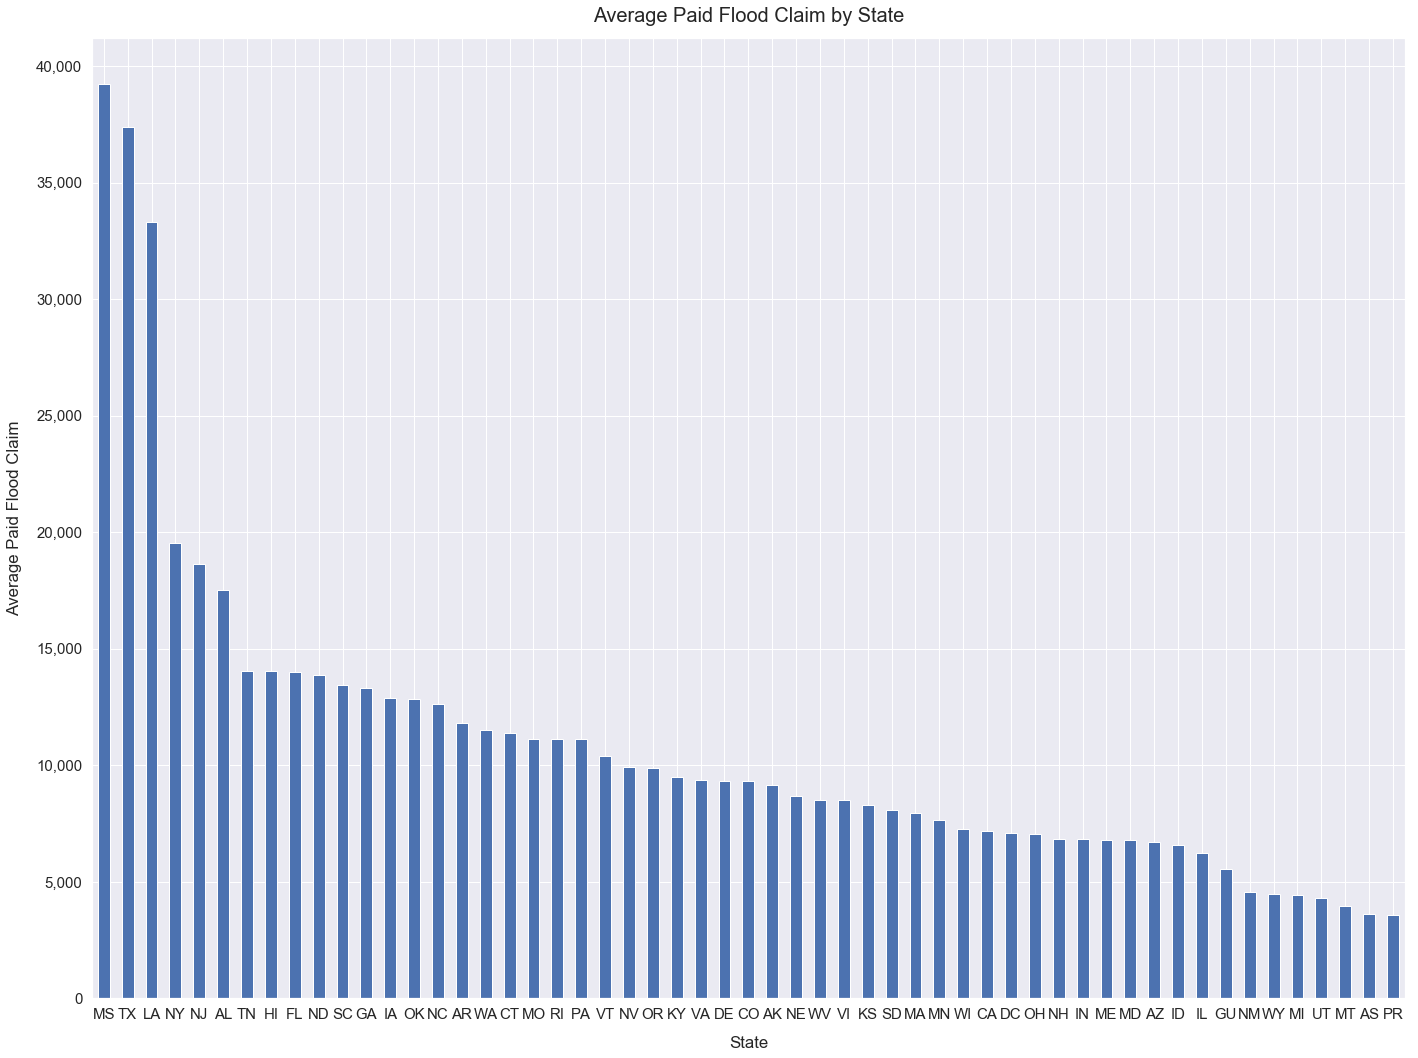

In [144]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_state.sort_values(by='average_paid_flood_claim', ascending=False).plot.bar(x='state', y='average_paid_flood_claim', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("State", labelpad=14)
plt.ylabel("Average Paid Flood Claim", labelpad=14)
plt.title("Average Paid Flood Claim by State", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-state-amount-average.png')

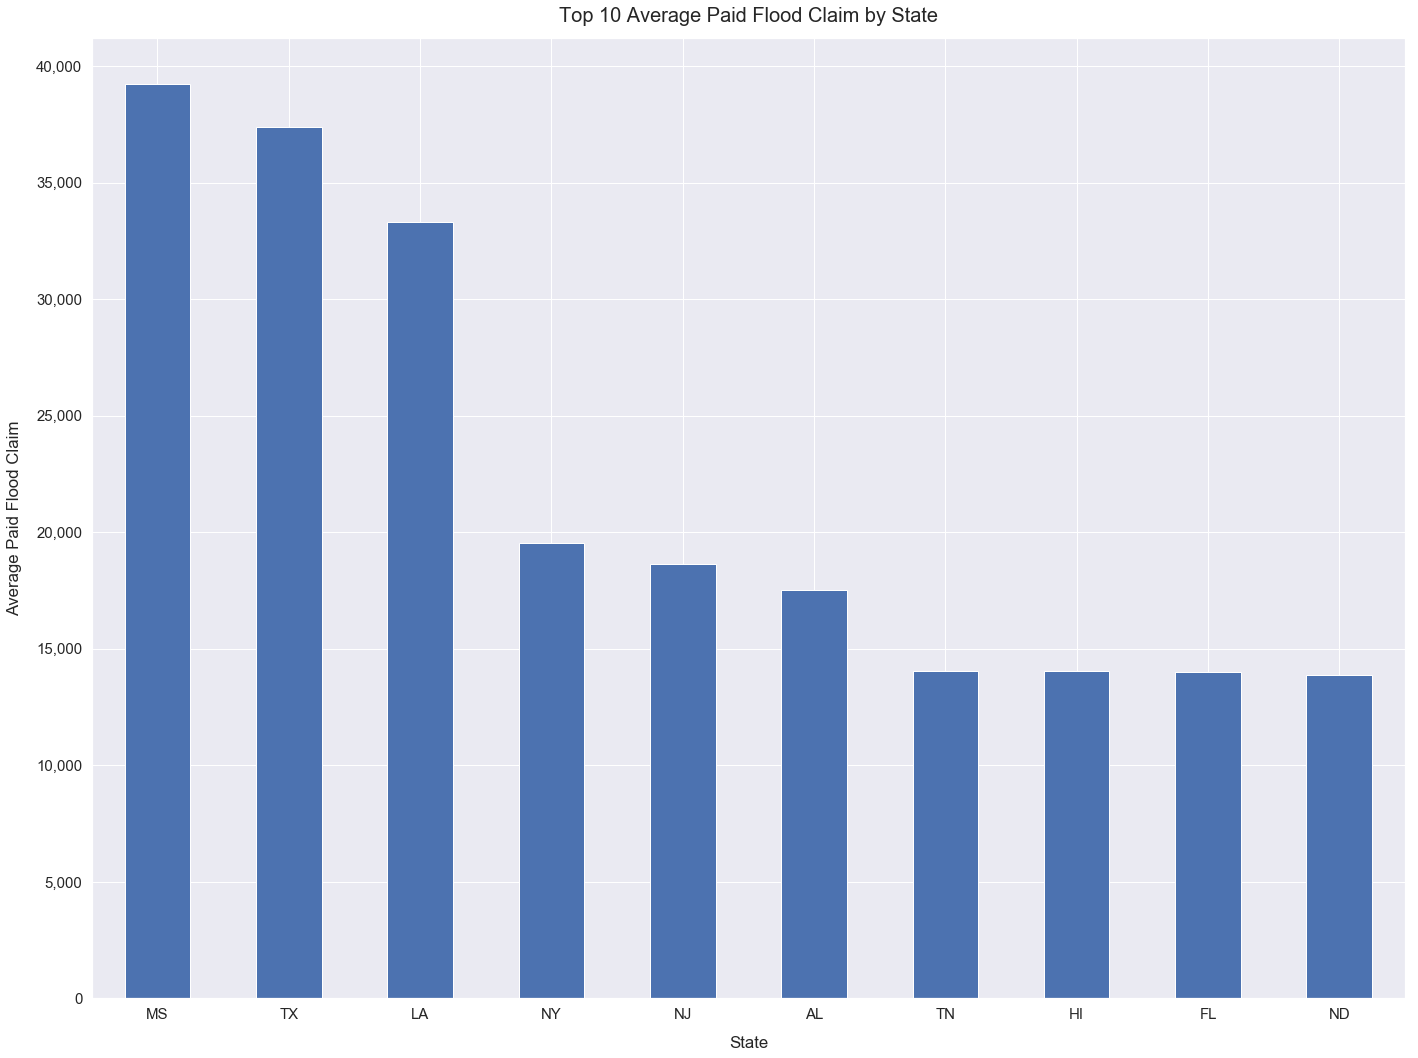

In [145]:
# defining our plot
sns.set(font_scale=1.4)
plt.subplots(figsize=(20,15))
ax = plt.subplot()

# formatting Y axis with comma
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

nfip_claims_state.sort_values(by='average_paid_flood_claim', ascending=False).head(10).plot.bar(x='state', y='average_paid_flood_claim', ax=ax, rot=0, color='b', fontsize=15, legend=False)
plt.xlabel("State", labelpad=14)
plt.ylabel("Average Paid Flood Claim", labelpad=14)
plt.title("Top 10 Average Paid Flood Claim by State", pad=16, fontsize=20)
plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-state-amount-average-top10.png')

# Mapping

In [59]:
# changing directories to Downloads folder
%cd ~/Downloads/

/Users/geribauer/Downloads


In [35]:
# dowloading the data with urllib.request.urlretrieve()
url = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip'

# retrieving the file and naming it as 'nfip_claims.gz'
urllib.request.urlretrieve(url, "cb_2018_us_state_500k.gz")

('cb_2018_us_state_500k.gz', <http.client.HTTPMessage at 0x1a2491f080>)

In [36]:
# unzipping the file
!unzip -d ~/Downloads/ cb_2018_us_state_500k.gz

Archive:  cb_2018_us_state_500k.gz
  inflating: /Users/geribauer/Downloads/cb_2018_us_state_500k.shp.ea.iso.xml  
  inflating: /Users/geribauer/Downloads/cb_2018_us_state_500k.shp.iso.xml  
  inflating: /Users/geribauer/Downloads/cb_2018_us_state_500k.shp  
  inflating: /Users/geribauer/Downloads/cb_2018_us_state_500k.shx  
  inflating: /Users/geribauer/Downloads/cb_2018_us_state_500k.dbf  
  inflating: /Users/geribauer/Downloads/cb_2018_us_state_500k.prj  
 extracting: /Users/geribauer/Downloads/cb_2018_us_state_500k.cpg  


In [60]:
states_shape = gpd.GeoDataFrame.from_file('cb_2018_us_state_500k.shp')


In [61]:
states_shape.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"(POLYGON ((-88.502966 30.215235, -88.491759 30..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"(POLYGON ((-75.72680699999999 35.935844, -75.7..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.002565 36.526588, -103.002188 3..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"(POLYGON ((-75.742406 37.80835, -75.741512 37...."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6431981036679 38.1690897960737, ..."


In [62]:
states_shape.shape

(56, 10)

In [63]:
states_shape.STATEFP = states_shape.STATEFP.astype('int64')

In [66]:
states_shape.sort_values(by='STATEFP', ascending=False).head(10)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
38,78,01802710,0400000US78,78,VI,United States Virgin Islands,00,348021896,1550236201,"(POLYGON ((-64.62798599999999 17.789326, -64.6..."
13,72,01779808,0400000US72,72,PR,Puerto Rico,00,8868896030,4922382562,"(POLYGON ((-65.23805299999999 18.321667, -65.2..."
45,69,01779809,0400000US69,69,MP,Commonwealth of the Northern Mariana Islands,00,472292529,4644252461,"(POLYGON ((146.051034 16.006741, 146.051668 16..."
44,66,01802705,0400000US66,66,GU,Guam,00,543555840,934337453,"(POLYGON ((144.645379 13.236271, 144.647162 13..."
37,60,01802701,0400000US60,60,AS,American Samoa,00,197759063,1307243754,"(POLYGON ((-168.145824 -14.547906, -168.145605..."
24,56,01779807,0400000US56,56,WY,Wyoming,00,251458544898,1867670745,"POLYGON ((-111.054556 45.000955, -111.04506604..."
49,55,01779806,0400000US55,55,WI,Wisconsin,00,140290039723,29344951758,"(POLYGON ((-86.95616699999999 45.355489, -86.9..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6431981036679 38.1690897960737, ..."
11,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"(POLYGON ((-122.570392 48.537853, -122.568628 ..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"(POLYGON ((-75.742406 37.80835, -75.741512 37...."


In [67]:
states_shape.STATEFP.unique()

array([28, 37, 40, 51, 54, 22, 26, 25, 16, 12, 31, 53, 35, 72, 46, 48,  6,
        1, 13, 42, 29,  8, 49, 47, 56, 36, 20,  2, 32, 17, 50, 30, 19, 45,
       33,  4, 11, 60, 78, 34, 24, 23, 15, 10, 66, 69, 44, 21, 39, 55, 41,
       38,  5, 18, 27,  9])

In [68]:
states_shape  = states_shape.loc[states_shape.STATEFP < 57]

In [69]:
states_shape.sort_values(by='STATEFP', ascending=False).head(10)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
24,56,01779807,0400000US56,56,WY,Wyoming,00,251458544898,1867670745,"POLYGON ((-111.054556 45.000955, -111.04506604..."
49,55,01779806,0400000US55,55,WI,Wisconsin,00,140290039723,29344951758,"(POLYGON ((-86.95616699999999 45.355489, -86.9..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6431981036679 38.1690897960737, ..."
11,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"(POLYGON ((-122.570392 48.537853, -122.568628 ..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"(POLYGON ((-75.742406 37.80835, -75.741512 37...."
30,50,01779802,0400000US50,50,VT,Vermont,00,23874175944,1030416650,"POLYGON ((-73.43773999999999 44.045006, -73.43..."
22,49,01455989,0400000US49,49,UT,Utah,00,212886221680,6998824394,"POLYGON ((-114.052962 37.592783, -114.052472 3..."
15,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"(POLYGON ((-94.718296 29.728855, -94.717207 29..."
23,47,01325873,0400000US47,47,TN,Tennessee,00,106802728188,2350123465,"POLYGON ((-90.31029799999999 35.004295, -90.30..."
14,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-104.057879 44.997605, -104.050783 4..."


In [70]:
states_shape.NAME.unique()

array(['Mississippi', 'North Carolina', 'Oklahoma', 'Virginia',
       'West Virginia', 'Louisiana', 'Michigan', 'Massachusetts', 'Idaho',
       'Florida', 'Nebraska', 'Washington', 'New Mexico', 'South Dakota',
       'Texas', 'California', 'Alabama', 'Georgia', 'Pennsylvania',
       'Missouri', 'Colorado', 'Utah', 'Tennessee', 'Wyoming', 'New York',
       'Kansas', 'Alaska', 'Nevada', 'Illinois', 'Vermont', 'Montana',
       'Iowa', 'South Carolina', 'New Hampshire', 'Arizona',
       'District of Columbia', 'New Jersey', 'Maryland', 'Maine',
       'Hawaii', 'Delaware', 'Rhode Island', 'Kentucky', 'Ohio',
       'Wisconsin', 'Oregon', 'North Dakota', 'Arkansas', 'Indiana',
       'Minnesota', 'Connecticut'], dtype=object)

In [71]:
states_shape = states_shape[['STUSPS', 'geometry']]

In [72]:
states_shape.head()

,STUSPS,geometry
0,MS,"(POLYGON ((-88.502966 30.215235, -88.491759 30..."
1,NC,"(POLYGON ((-75.72680699999999 35.935844, -75.7..."
2,OK,"POLYGON ((-103.002565 36.526588, -103.002188 3..."
3,VA,"(POLYGON ((-75.742406 37.80835, -75.741512 37...."
4,WV,"POLYGON ((-82.6431981036679 38.1690897960737, ..."


(-197.09527795, 197.72483895, 16.28762095, 73.98790205000002)

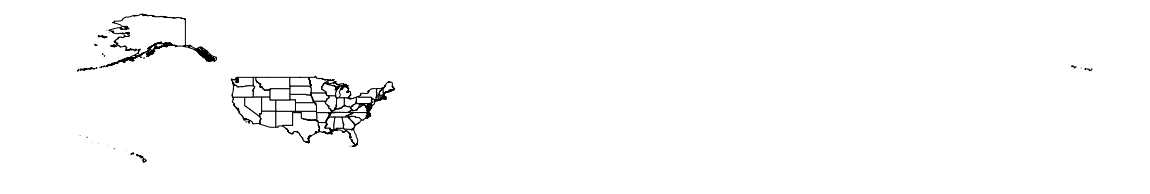

In [73]:
fig, ax = plt.subplots(figsize=(20,15))

states_shape.plot(ax=ax, color='w', edgecolor='black')

# Insert comment here
plt.axis('off')

In [74]:
delete_states = ['AK', 'HI']

In [76]:
states_shape  = states_shape.loc[~states_shape['STUSPS'].isin(delete_states)]

(-2259318.9898424284,
 2743787.7776512564,
 -2259441.9737315555,
 874818.5571526415)

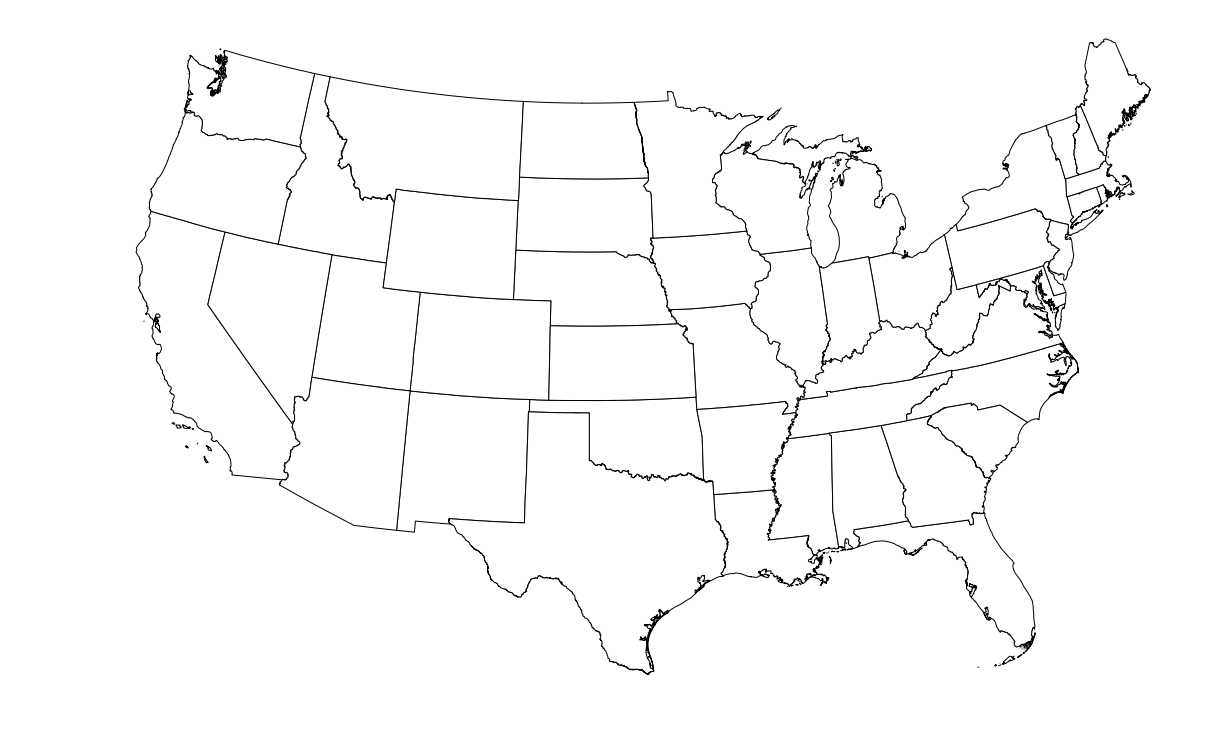

In [146]:
fig, ax = plt.subplots(figsize=(20,15))

states_shape.plot(ax=ax, color='w', edgecolor='black')

# Insert comment here
plt.axis('off')

In [147]:
states_shape.crs

{'init': 'epsg:2163', 'no_defs': True}

In [148]:
states_shape = states_shape.to_crs(epsg=2163)

(-2259318.9898424284,
 2743787.7776512564,
 -2259441.9737315555,
 874818.5571526419)

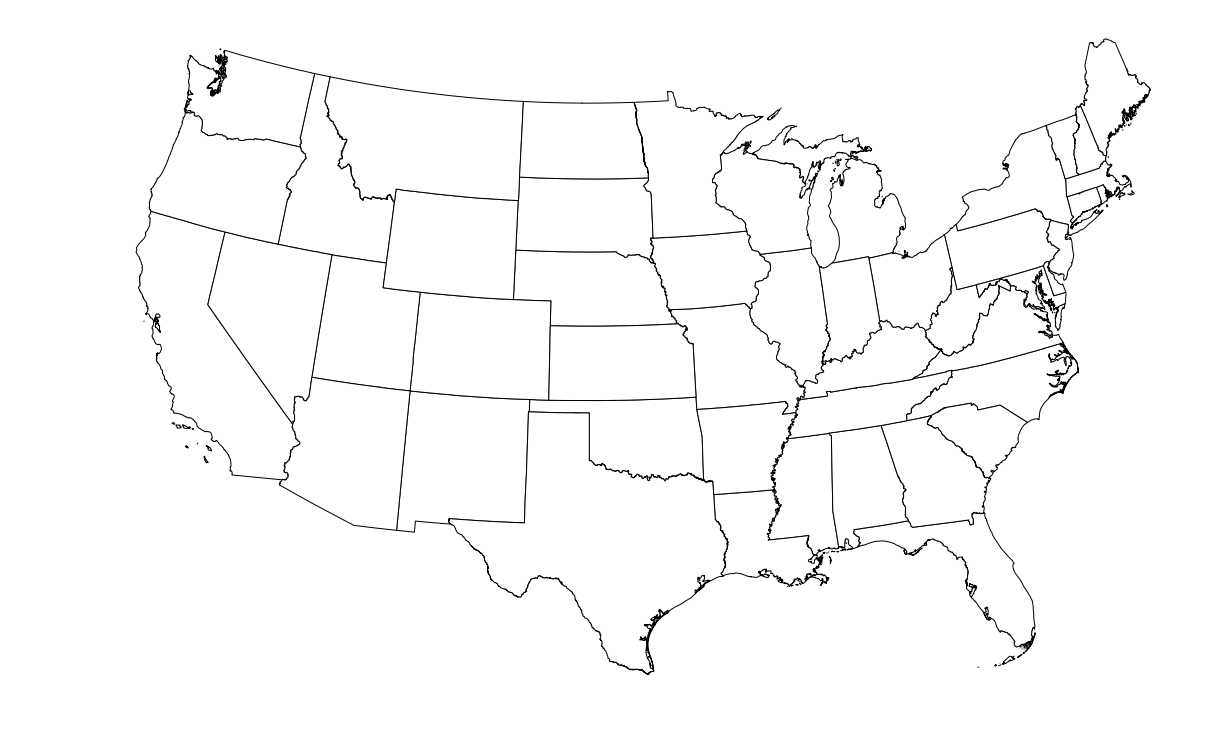

In [149]:
fig, ax = plt.subplots(figsize=(20,15))

states_shape.plot(ax=ax, color='w', edgecolor='black')

# Insert comment here
plt.axis('off')

In [98]:
nfip_claims_state_map = states_shape.merge(nfip_claims_state, left_on="STUSPS", 
              right_on="state")

In [99]:
nfip_claims_state_map.head()

,STUSPS,geometry,state,claimscount,amountpaidontotalclaim,average_paid_flood_claim
0,MS,(POLYGON ((1109990.968252456 -1565553.47260314...,MS,62715,2.460968e+09,39240.493723
1,NC,(POLYGON ((2154835.72962173 -692236.3180788131...,NC,101247,1.277994e+09,12622.535248
2,OK,POLYGON ((-268956.1527428209 -936541.911155743...,OK,12684,1.626293e+08,12821.612508
3,VA,(POLYGON ((2098181.788299462 -490386.322096654...,VA,49270,4.619380e+08,9375.643711
4,WV,POLYGON ((1506493.502378316 -601384.4489765986...,WV,27313,2.323520e+08,8507.012076


In [150]:
nfip_claims_state_map.shape

(49, 7)

In [151]:
nfip_claims_state_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 7 columns):
STUSPS                       49 non-null object
geometry                     49 non-null object
state                        49 non-null object
claimscount                  49 non-null int64
amountpaidontotalclaim       49 non-null float64
average_paid_flood_claim     49 non-null float64
amountpaidontotalclaim-bn    49 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 3.1+ KB


In [152]:
nfip_claims_state_map['amountpaidontotalclaim-bn']  = nfip_claims_state_map.amountpaidontotalclaim / 1000000000

In [153]:
nfip_claims_state_map.head()

,STUSPS,geometry,state,claimscount,amountpaidontotalclaim,average_paid_flood_claim,amountpaidontotalclaim-bn
0,MS,(POLYGON ((1109990.968252456 -1565553.47260314...,MS,62715,2.460968e+09,39240.49,2.460968
1,NC,(POLYGON ((2154835.72962173 -692236.3180788131...,NC,101247,1.277994e+09,12622.54,1.277994
2,OK,POLYGON ((-268956.1527428209 -936541.911155743...,OK,12684,1.626293e+08,12821.61,0.162629
3,VA,(POLYGON ((2098181.788299462 -490386.322096654...,VA,49270,4.619380e+08,9375.64,0.461938
4,WV,POLYGON ((1506493.502378316 -601384.4489765986...,WV,27313,2.323520e+08,8507.01,0.232352


In [154]:
nfip_claims_state_map = nfip_claims_state_map.round({'average_paid_flood_claim': 2, 'amountpaidontotalclaim-bn': 2})

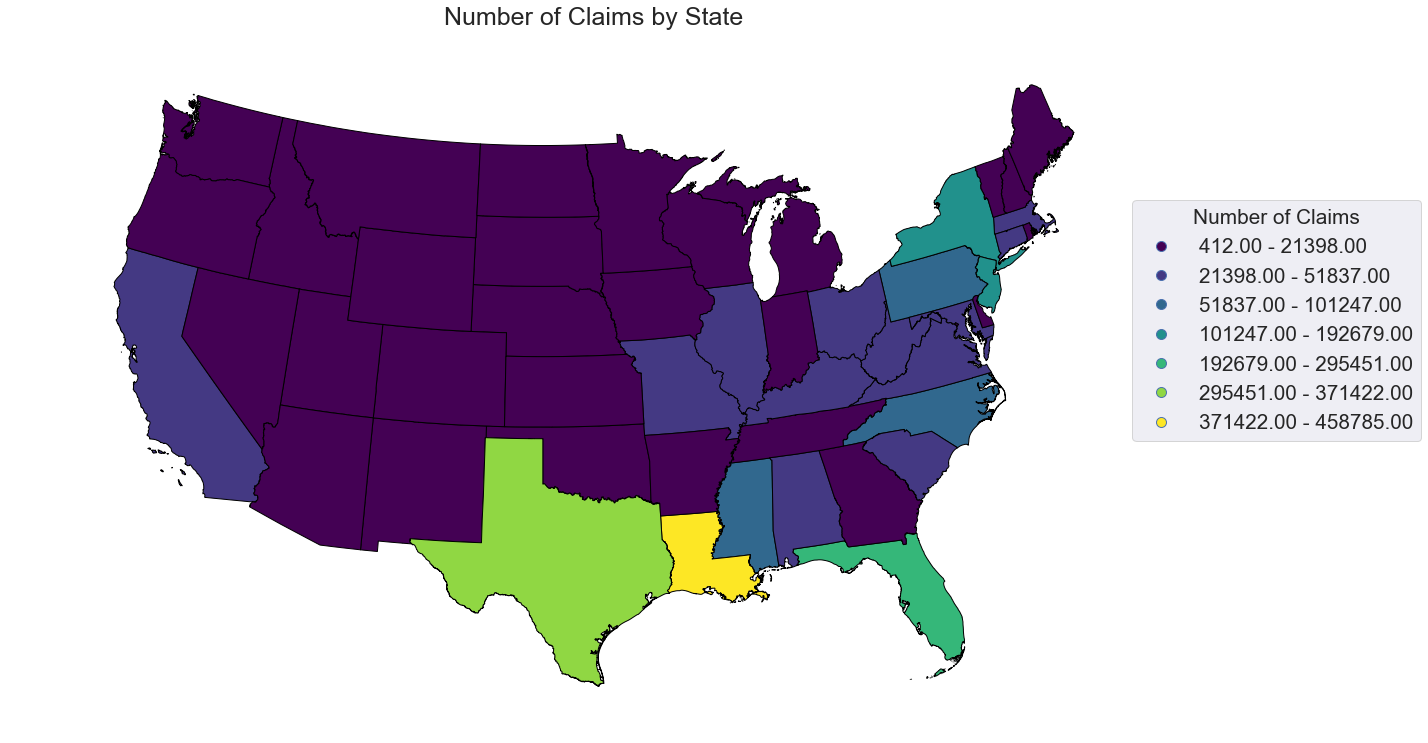

In [159]:
# defining our plot
plt.subplots(figsize=(20,15))
ax = plt.subplot()

nfip_claims_state_map.plot(column="claimscount", ax=ax, k=7, 
                   scheme='fisher_jenks', label=True, legend=True,
                   legend_kwds={'loc': 'lower left', 'title': 'Number of Claims', 
                   'title_fontsize': 'xx-large','fontsize': 'xx-large', 'bbox_to_anchor': (1, 0.4)},
                   cmap='viridis', edgecolor='black')

ax.set_title("Number of Claims by State", fontsize=25, pad=30)

plt.tight_layout()

plt.axis('off')

#saving figure
plt.savefig('figures/claims-count-map.png')

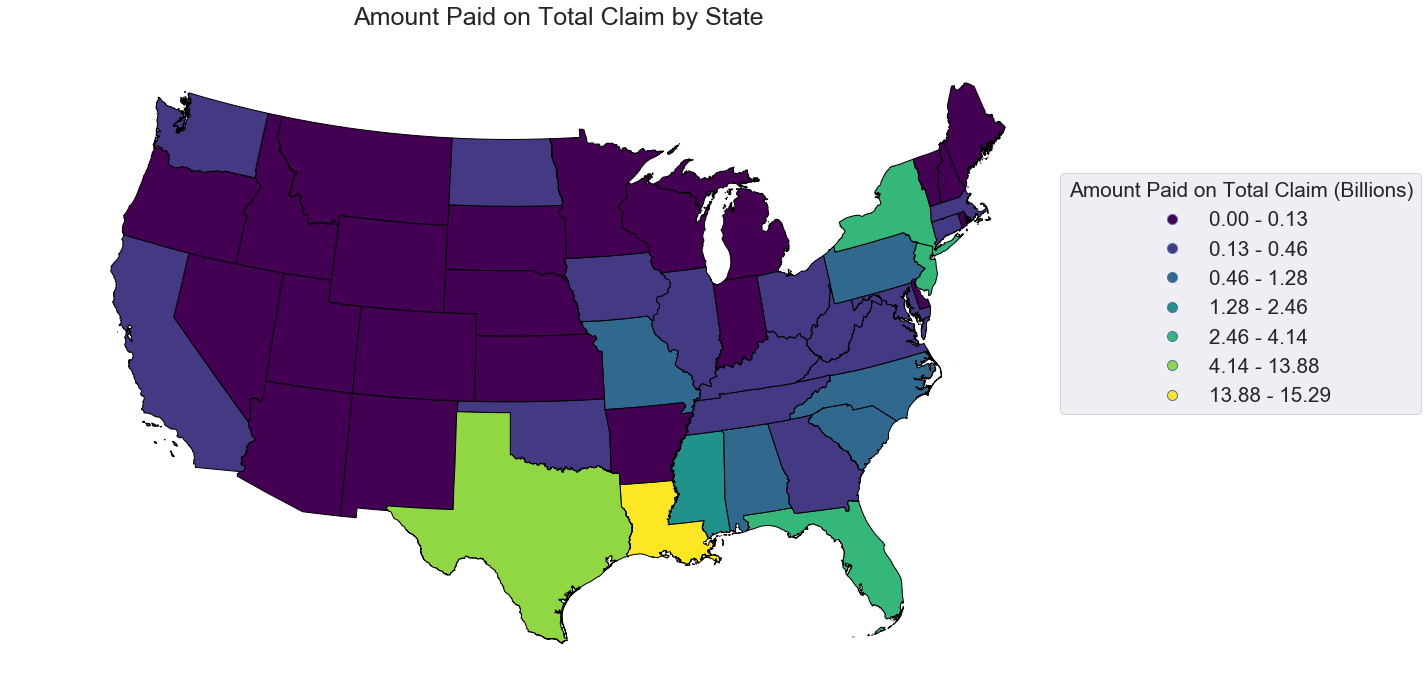

In [160]:
# defining our plot
plt.subplots(figsize=(20,15))
ax = plt.subplot()

nfip_claims_state_map.plot(column="amountpaidontotalclaim-bn", ax=ax, k=7, 
                   scheme='fisher_jenks', label=True, legend=True,
                   legend_kwds={'loc': 'lower left', 'title': 'Amount Paid on Total Claim (Billions)', 
                   'title_fontsize': 'xx-large','fontsize': 'xx-large', 'bbox_to_anchor': (1, 0.4)},
                   cmap='viridis', edgecolor='black')

ax.set_title("Amount Paid on Total Claim by State", fontsize=25, pad=30)

plt.tight_layout()

plt.axis('off')

#saving figure
plt.savefig('figures/claims-paid-amount-map.png')

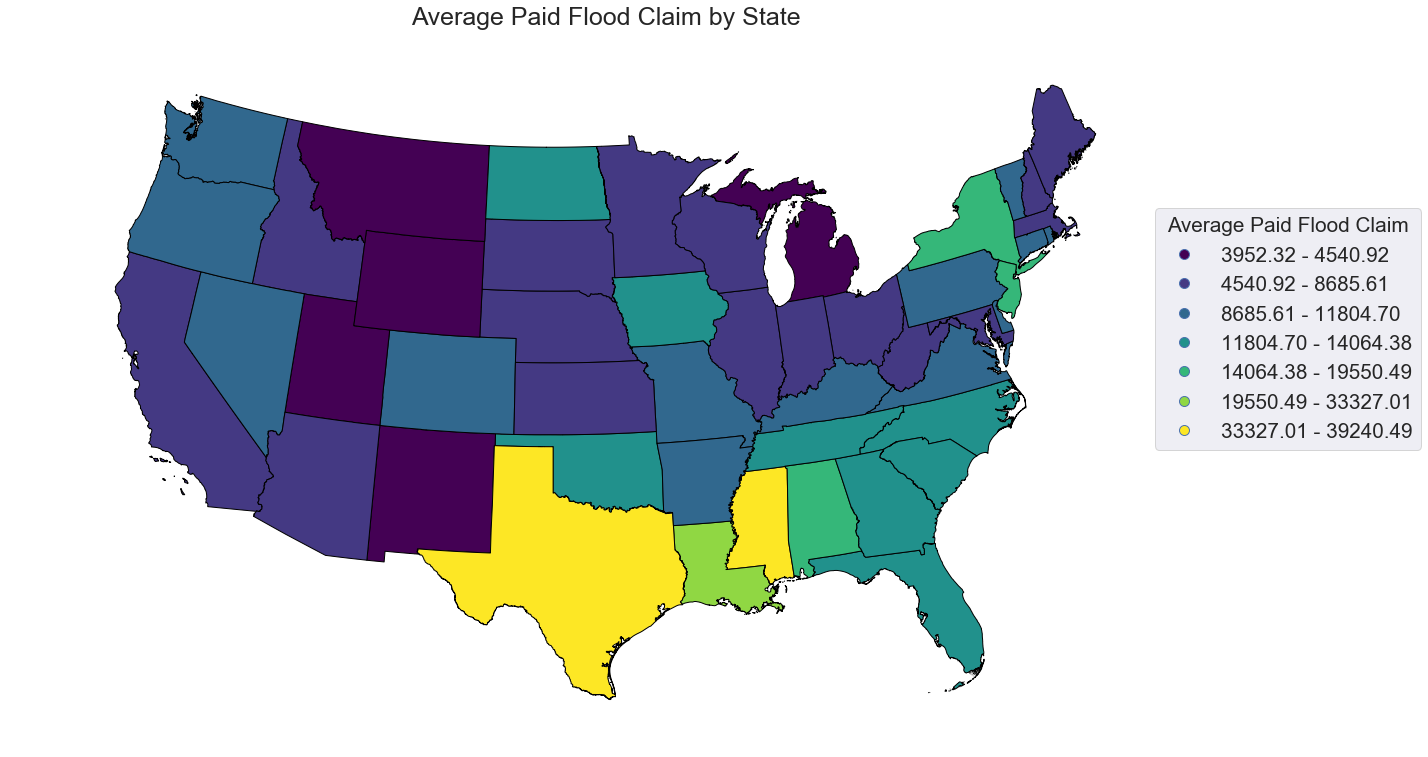

In [161]:
# defining our plot
plt.subplots(figsize=(20,15))
ax = plt.subplot()

nfip_claims_state_map.plot(column="average_paid_flood_claim", ax=ax, k=7, 
                   scheme='fisher_jenks', label=True, legend=True,
                   legend_kwds={'loc': 'lower left', 'title': 'Average Paid Flood Claim', 
                   'title_fontsize': 'xx-large','fontsize': 'xx-large', 'bbox_to_anchor': (1, 0.4)},
                   cmap='viridis', edgecolor='black')

ax.set_title("Average Paid Flood Claim by State", fontsize=25, pad=30)

plt.tight_layout()

plt.axis('off')

#saving figure
plt.savefig('figures/claims-paid-amount-average-map.png')

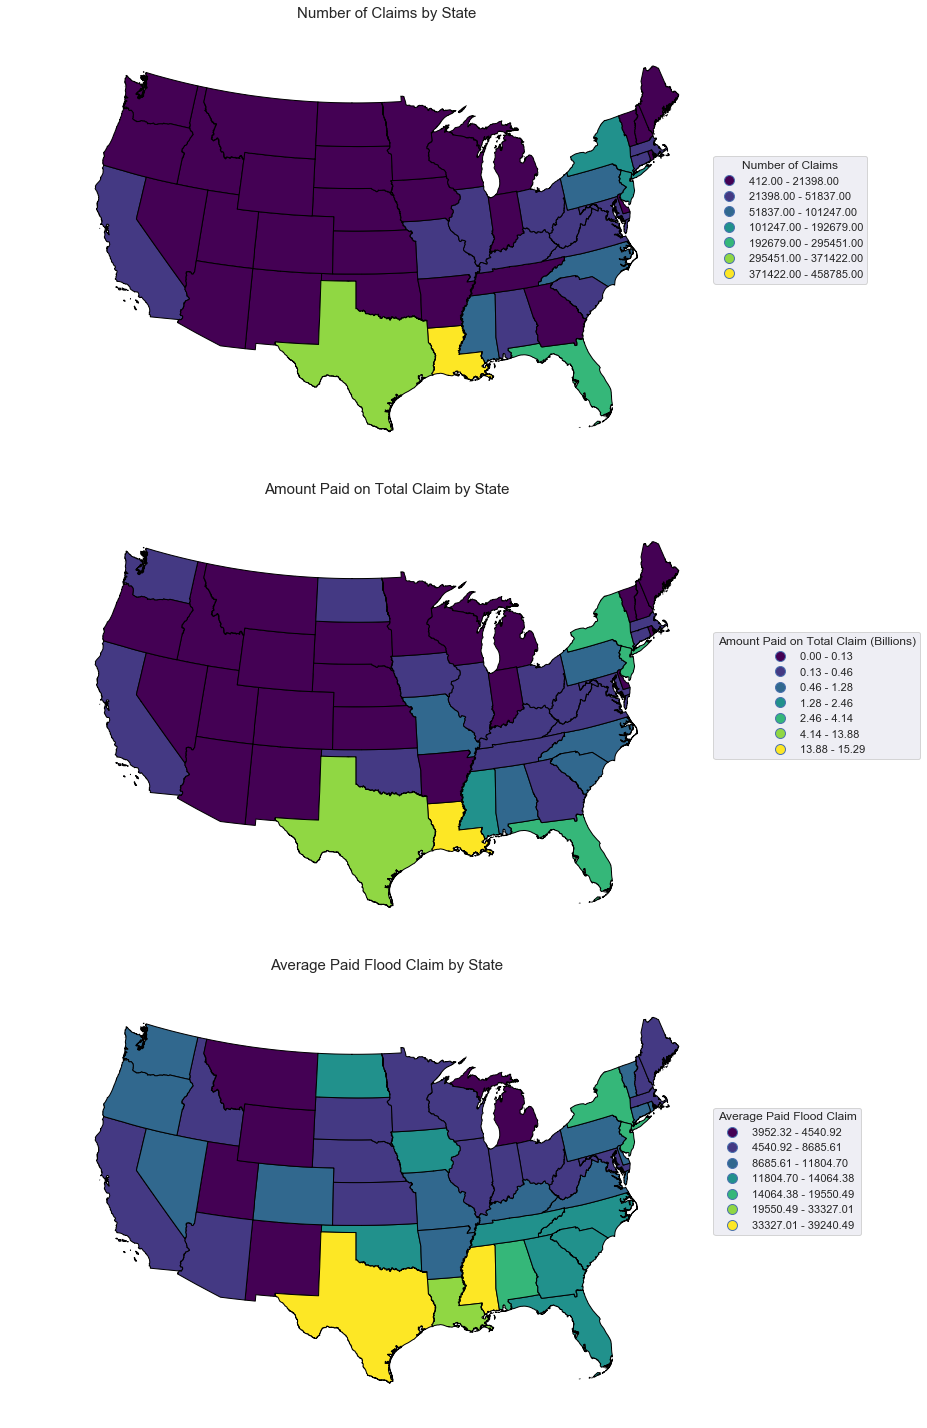

In [162]:
sns.set(font_scale=1)
fig = pl.figure(figsize=(20,20))

# adding first subplot
ax = fig.add_subplot(311)

nfip_claims_state_map.plot(column="claimscount", ax=ax, k=7, 
                   scheme='fisher_jenks', label=True, legend=True,
                   cmap='viridis', edgecolor='black', legend_kwds={'loc': 'lower left', 
                   'title': 'Number of Claims', 'bbox_to_anchor': (1, 0.4)})

ax.set_title("Number of Claims by State", fontsize=15, pad=30)
plt.axis('off')

# adding second subplot
ax = fig.add_subplot(312)

nfip_claims_state_map.plot(column="amountpaidontotalclaim-bn", ax=ax, k=7, 
                   scheme='fisher_jenks', label=True, legend=True,
                   cmap='viridis', edgecolor='black', legend_kwds={'loc': 'lower left', 
                   'title': 'Amount Paid on Total Claim (Billions)', 'bbox_to_anchor': (1, 0.4)})

ax.set_title("Amount Paid on Total Claim by State", fontsize=15, pad=30)
plt.axis('off')


# adding third subplot
ax = fig.add_subplot(313)

nfip_claims_state_map.plot(column="average_paid_flood_claim", ax=ax, k=7, 
                   scheme='fisher_jenks', label=True, legend=True,
                   cmap='viridis', edgecolor='black', legend_kwds={'loc': 'lower left', 
                   'title': 'Average Paid Flood Claim', 'bbox_to_anchor': (1, 0.4)})

ax.set_title("Average Paid Flood Claim by State", fontsize=15, pad=30)
plt.axis('off')

plt.tight_layout()

#saving figure
plt.savefig('figures/nfip-claims-by-state-maps.png')